In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

import glob
from sklearn.metrics import classification_report
from scipy.stats import pearsonr

from utils import de_score
import utils as ut
import random
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')
from scipy.stats import ranksums,ttest_ind


<div class="alert alert-info">

**Note**
    
This notebook provides analysis on the umap, the performance score, and the predictive gene module score correlation. Require input is the h5ad file of the transfer learning
    
</div>  

# Set parameters of scanpy

In [2]:
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=300, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

Input h5ad of trained datasets

In [170]:
# List all files in the directoty
h5ad_list = glob.glob("E:/code/scDEAL-main/save/adata\\*.h5ad")

In [171]:
h5ad_list

['E:/code/scDEAL-main/save/adata\\GSE1108941214data_GSE110894_drug_I.BET.762_bottle_128_edim_512,256_pdim_256,128_model_DAE_dropout_0.1_gene_T_lr_0.01_mod_new_sam_downsampling.h5ad',
 'E:/code/scDEAL-main/save/adata\\GSE110894integrate_data_GSE110894_drug_I.BET.762_bottle_512_edim_256,128_pdim_128,64_model_DAE_dropout_0.1_gene_F_lr_0.5_mod_new_sam_upsampling.h5ad',
 'E:/code/scDEAL-main/save/adata\\GSE1122741214data_GSE112274_drug_GEFITINIB_bottle_64_edim_512,256_pdim_256,128_model_DAE_dropout_0.1_gene_T_lr_0.1_mod_new_sam_no.h5ad',
 'E:/code/scDEAL-main/save/adata\\GSE117872_HN1201214data_GSE117872_HN120_drug_CISPLATIN_bottle_32_edim_256,128_pdim_128,64_model_DAE_dropout_0.3_gene_T_lr_0.5_mod_new_sam_SMOTE.h5ad',
 'E:/code/scDEAL-main/save/adata\\GSE117872_HN120integrate_data_GSE117872_HN120_drug_CISPLATIN_bottle_512_edim_256,128_pdim_128,64_model_DAE_dropout_0.3_gene_F_lr_0.01_mod_new_sam_SMOTE.h5ad',
 'E:/code/scDEAL-main/save/adata\\GSE117872_HN1371214data_GSE117872_HN137_drug_CISP

Define cell type column name in the meta data file of each dataset

In [172]:
CELL_TYPE_KEY = {"GSE117872_HN137":"cell_color","GSE117872_HN120":"cell_color","GSE110894":"Sample name","GSE140440":"sensitivity","GSE112274":"sensitivity",
                "GSE149383":"sensitivity"}

Select data set of interested

In [173]:
h5ad_list = [h5ad_list[4]]

In [174]:
h5ad_list

['E:/code/scDEAL-main/save/adata\\GSE117872_HN120integrate_data_GSE117872_HN120_drug_CISPLATIN_bottle_512_edim_256,128_pdim_128,64_model_DAE_dropout_0.3_gene_F_lr_0.01_mod_new_sam_SMOTE.h5ad']

In [175]:
intested = "GSE117872_HN120"

# Generated 3 figures comparing before, after tarnsfer, ground truth

And it will save the F1 score before and after the transfer learning

In [25]:
# Random score test
def ran_test_score(adata,n_iters=1000):
    ran_results1 = []
    ran_results2 = []

    s_score,s_pval = pearsonr(adata.obs["1_score"],adata.obs["Sensitive_score"])
    r_score,r_pval = pearsonr(adata.obs["0_score"],adata.obs["Resistant_score"])


    for i in range(0,n_iters):

        gl1 = random.sample(list(adata.var.index),50)
        adata=sc.tl.score_genes(adata, gene_list=gl1,score_name="l1_score",copy=True)

        rand_score1,rand_pval1 = pearsonr(adata.obs["l1_score"],adata.obs["Sensitive_score"])
        rand_score2,rand_pval2 = pearsonr(adata.obs["l1_score"],adata.obs["Resistant_score"])

        ran_results1.append(rand_score1)
        ran_results2.append(rand_score2)
        
        
    return adata,ran_results1, s_score,s_pval ,ran_results2,r_score,r_pval

In [26]:
# Functioin to show p value on the figure
def p_string(l,score):
    score = sum(l>=score)/len(l)
    if(score==0):
        return "p < 0.001"
    else:
        return "p =" + " "+str(score)

# Show the prediction probability before transfer and after on UMAP

Index(['cell_color', 'patient_id', 'origin', 'drug_status', 'cluster',
       'pca_clusters', 'pagoda_clusters', 'Unnamed: 8', 'sensitive',
       'sensitivity', 'Resistant_score', 'Sensitive_score', 'n_genes',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt-',
       'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps',
       'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin',
       'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label',
       'rest_preds'],
      dtype='object')



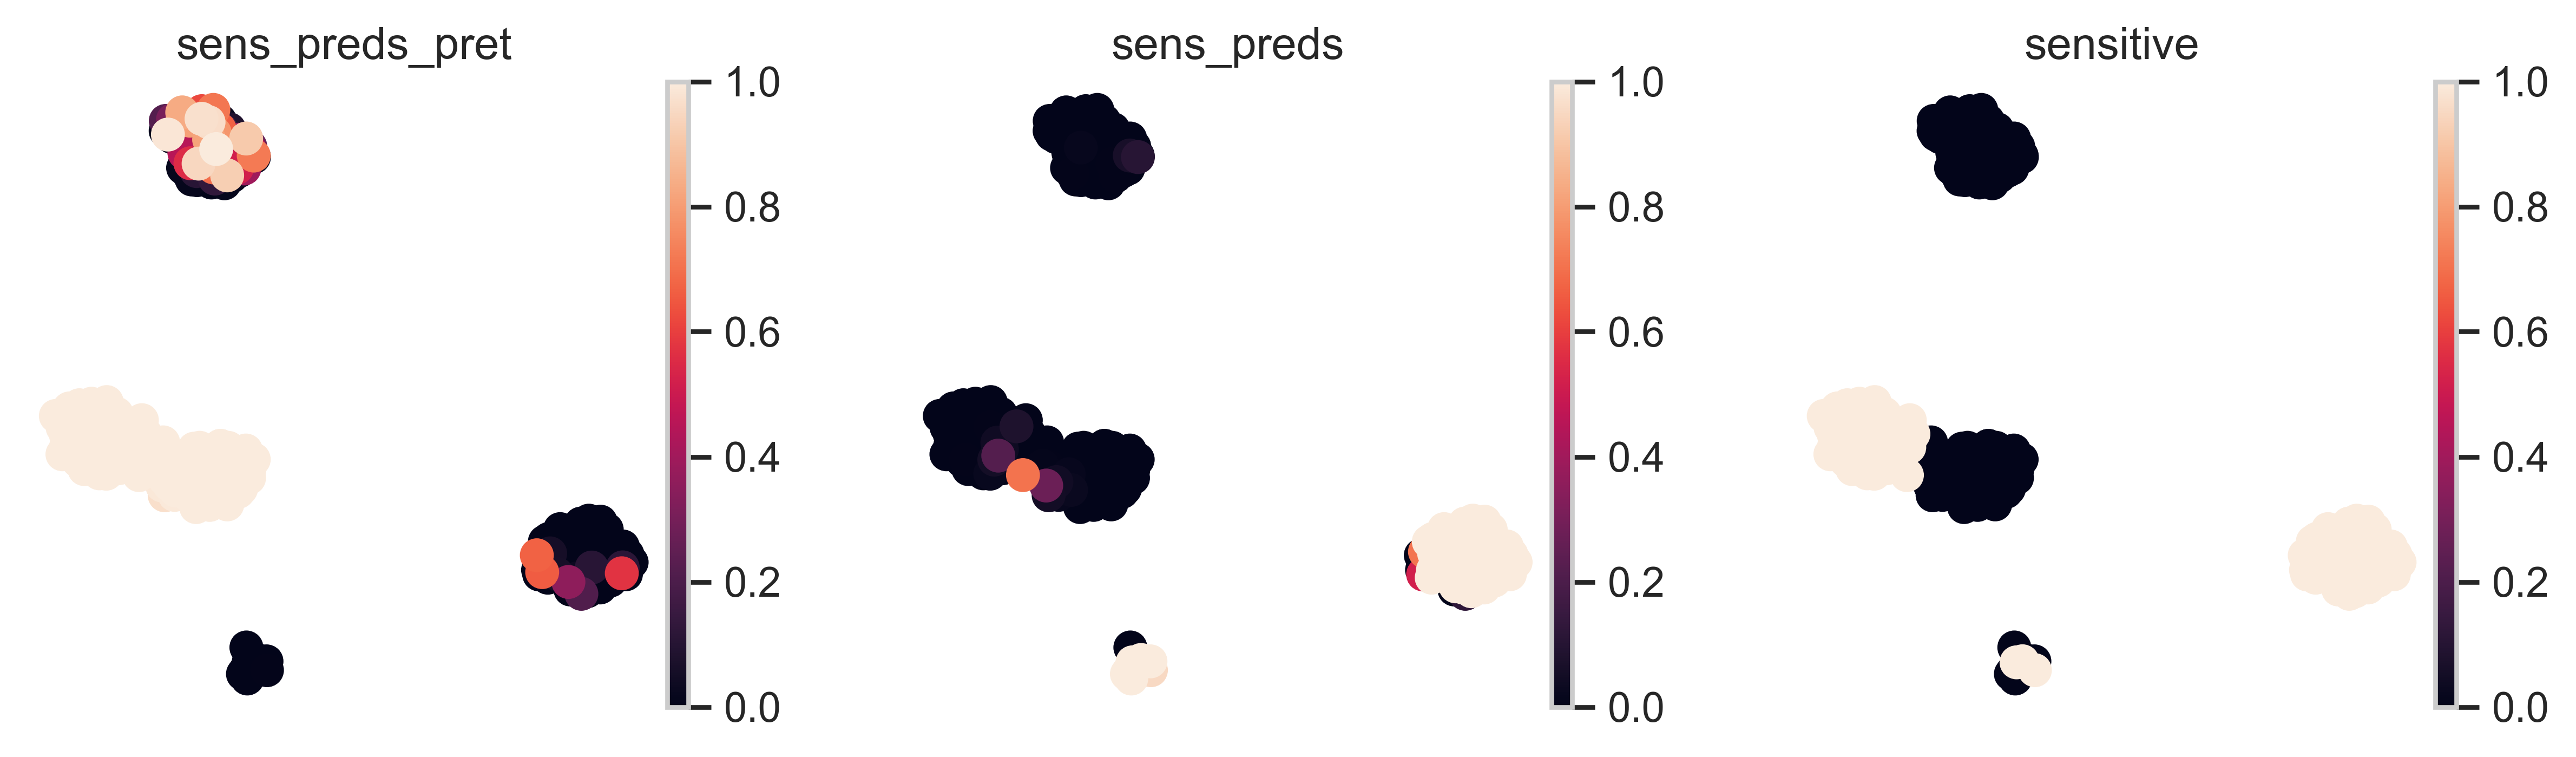

In [176]:
from sklearn.metrics import (auc, average_precision_score,
                             classification_report, mean_squared_error,
                             precision_recall_curve, r2_score, roc_auc_score)

names = []
score = []
model = []

interes_adata = None

for f in h5ad_list:
    
    
    adata = sc.read_h5ad(filename=f)
    adata.uns['log1p']["base"] = None
    
    if(f.find("117872")>0):
        adata = adata[adata.obs['cluster']!="Holiday"]

    pretrain_label = adata.obs['sens_label_pret']
    sens_label = adata.obs['sens_label']
    
        
    print(adata.obs.columns)

    grouth_truth = adata.obs['sensitive']
    sens_pb_pret = adata.obs['sens_preds_pret']
    sens_label_pret = adata.obs['sens_label_pret']
    sens_pb = adata.obs['sens_preds']

    name = f.split("1214")[0].split("\\")[1]
    
    if(name=="GSE110894"):
        adata=adata[(adata.obs["Sample name"] != "EMPTY") & \
                    (adata.obs["Sample name"] != "EMPTY ") ,: ]
    
    
    
    report_dict_pret = classification_report(grouth_truth, pretrain_label, output_dict=True)
    classification_report_pret_df = pd.DataFrame(report_dict_pret).T
    f1score_pret = report_dict_pret['weighted avg']['f1-score']
    ap_pret = average_precision_score(grouth_truth, sens_pb_pret)
    auroc_pret = roc_auc_score(grouth_truth, sens_label_pret)

    
    report_dict = classification_report(grouth_truth, sens_label, output_dict=True)
    classification_report_df = pd.DataFrame(report_dict).T
    f1score = report_dict['weighted avg']['f1-score']
    ap = average_precision_score(grouth_truth, sens_pb)
    auroc = roc_auc_score(grouth_truth, sens_label)
    
    names.append(name)
    score.append(f1score_pret)
    model.append("before")
    
    names.append(name)
    score.append(f1score)
    model.append("transfer")

    result = pd.DataFrame({"f1":[f1score_pret,f1score],
                          "ap":[ap_pret,ap],
                          "auroc":[auroc_pret,auroc]},index=["pretrain","transfer"])
    
    print()
    # Save the figure
    sc.pl.umap(adata,color=['sens_preds_pret','sens_preds','sensitive'],save="report_compare"+name + '.tiff')
    # Save the f1 score before and after
    result.to_csv("save/results/report_compare"+name + '.csv')
    
    # Cal pred senstivie score
    adata = ut.de_score(adata,clustername='sens_label')
    
    if(f.find(intested)>0):
        interes_adata = adata

In [177]:
adata=interes_adata

# Compare the score before and after the transfer learning

In [178]:
result_compare = pd.DataFrame({"data":names,
                      "transfer":model,
                      "score":score})

In [179]:
result_compare

,data,transfer,score
0,GSE117872_HN120integrate_data_GSE117872_HN120_...,before,0.458492
1,GSE117872_HN120integrate_data_GSE117872_HN120_...,transfer,0.711326


# Plot the umap highlighting the wrong predictions

In [180]:
idx = adata.obs["sensitive"] != adata.obs["sens_label"]

In [181]:
adata.obs['wrong'] = pd.NA

In [182]:
adata.obs.loc[idx,'wrong'] = "Wrong"
adata.obs['wrong'] = adata.obs.wrong.astype('category')

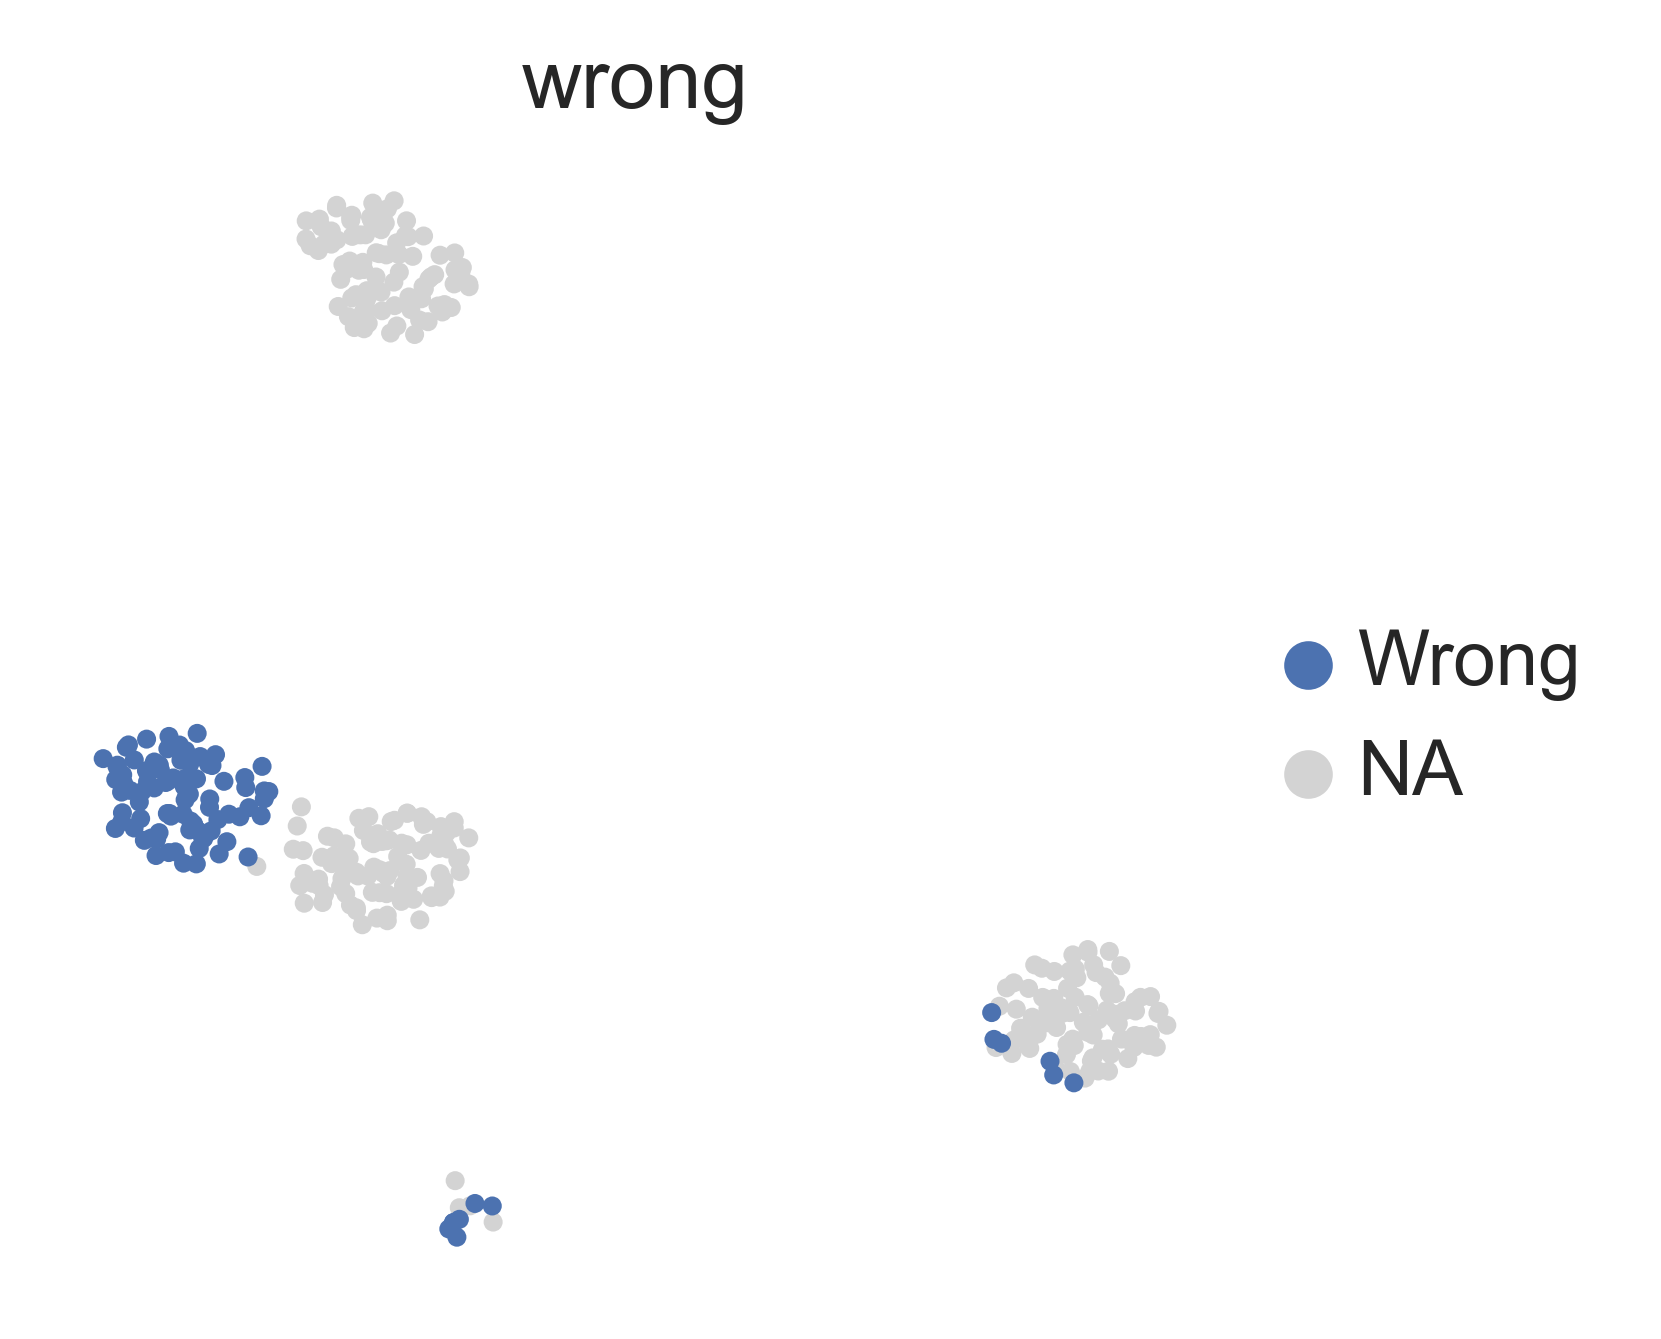

In [183]:
sc.pl.umap(adata,color="wrong",size=30)

In [184]:
name = intested

Calculate the numer of wrong predictions in each cell type

In [185]:
df = adata.obs[[CELL_TYPE_KEY[name],"wrong"]]\
.groupby([CELL_TYPE_KEY[name]])\
.aggregate(['count','size'])\
.reset_index()
df['data'] = name
df

cell_color wrong                  data
             count size                 
0     HN120M    87   91  GSE117872_HN120
1   HN120MCR     1   92  GSE117872_HN120
2     HN120P     6   90  GSE117872_HN120
3   HN120PCR     6   95  GSE117872_HN120

# Overview comparing the prediction and the ground Truth

In [186]:
adata.obs["pred_binary"] = adata.obs["sens_label"]
adata.obs.sens_label = adata.obs.sens_label.cat.rename_categories({1:"Sensitive", 0:"Resistant"})

In [187]:
adata.obs=adata.obs.rename(columns={"sensitivity": "Ground Truth", "sens_label": "Prediction"})

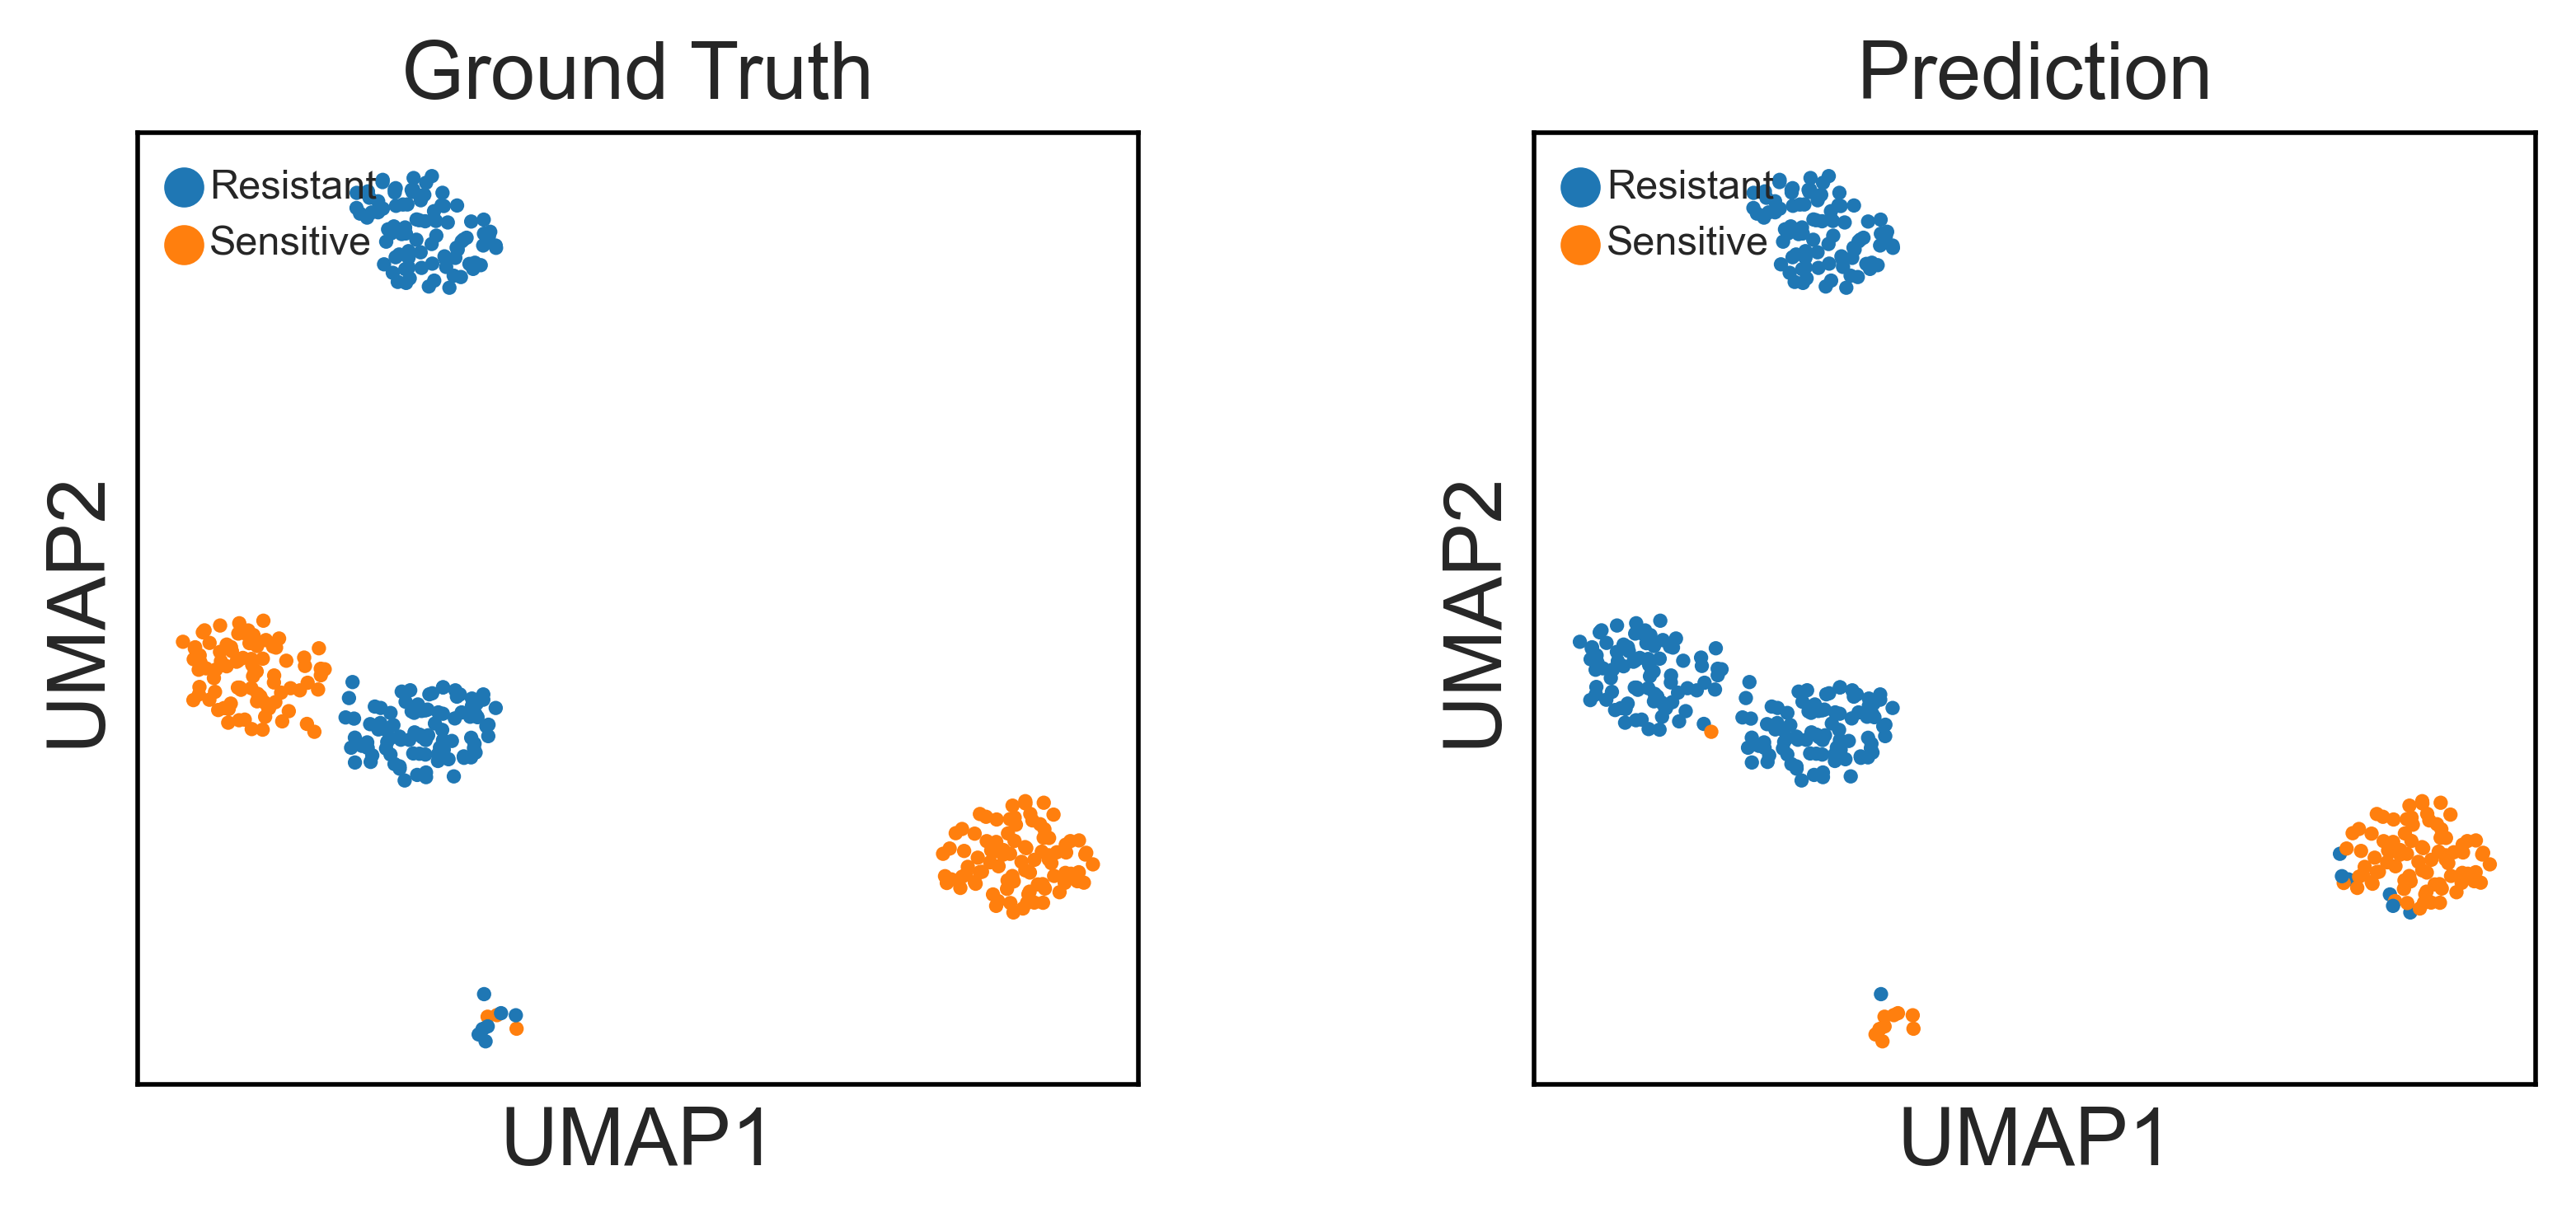

In [188]:
sc.settings.set_figure_params(dpi=250,  figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures
ax = sc.pl.umap(adata,color=['Ground Truth',"Prediction"],size=25,show=False)
# ax[0].legend().remove()
ax[0].legend(loc ='upper left',frameon=False, fontsize='7') 
ax[1].legend(loc ='upper left',frameon=False, fontsize='7') 
plt.savefig("save/figures/figure2A_1"+name + ".tiff")

In [189]:
adata.obs

,cell_color,patient_id,origin,drug_status,cluster,pca_clusters,pagoda_clusters,Unnamed: 8,sensitive,Ground Truth,...,leiden_origin,sens_preds_pret,sens_label_pret,sens_preds,Prediction,rest_preds,0_score,1_score,wrong,pred_binary
RHH2177,HN120P,cyan,HN120,Primary,Sensitive,4,2,3,1,Sensitive,...,3,0.000001,0,9.999998e-01,Sensitive,4.082925e-07,-0.686758,3.299789,NaN,1
RHH2178,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,3,0.000081,0,9.999396e-01,Sensitive,2.949506e-05,-0.919941,3.129097,NaN,1
RHH2179,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,3,0.000534,0,9.999986e-01,Sensitive,4.844372e-07,-0.677126,3.164974,NaN,1
RHH2180,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,3,0.000049,0,9.999959e-01,Sensitive,6.777409e-06,-0.725554,3.252522,NaN,1
RHH2181,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,3,0.000245,0,1.000000e+00,Sensitive,5.099429e-09,-0.711504,2.760890,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHH3106,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0,0.999917,1,3.920096e-06,Resistant,9.999965e-01,1.906851,0.161723,NaN,0
RHH3107,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0,0.999996,1,2.147436e-05,Resistant,9.999537e-01,1.687337,-0.156999,NaN,0
RHH3108,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0,1.000000,1,3.585559e-08,Resistant,1.000000e+00,2.000162,-0.264605,NaN,0
RHH3109,HN120MCR,green,HN120,Metastatic,Resistant,1,4,2,0,Resistant,...,0,0.999324,1,1.780238e-04,Resistant,9.999098e-01,2.123945,0.235337,NaN,0


In [190]:
try:
    adata.obs["Sample name"] = adata.obs["cell_color"]
except:
    adata.obs["Sample name"] = adata.obs["Ground Truth"]

# Show the prediction probablity of drug resistant

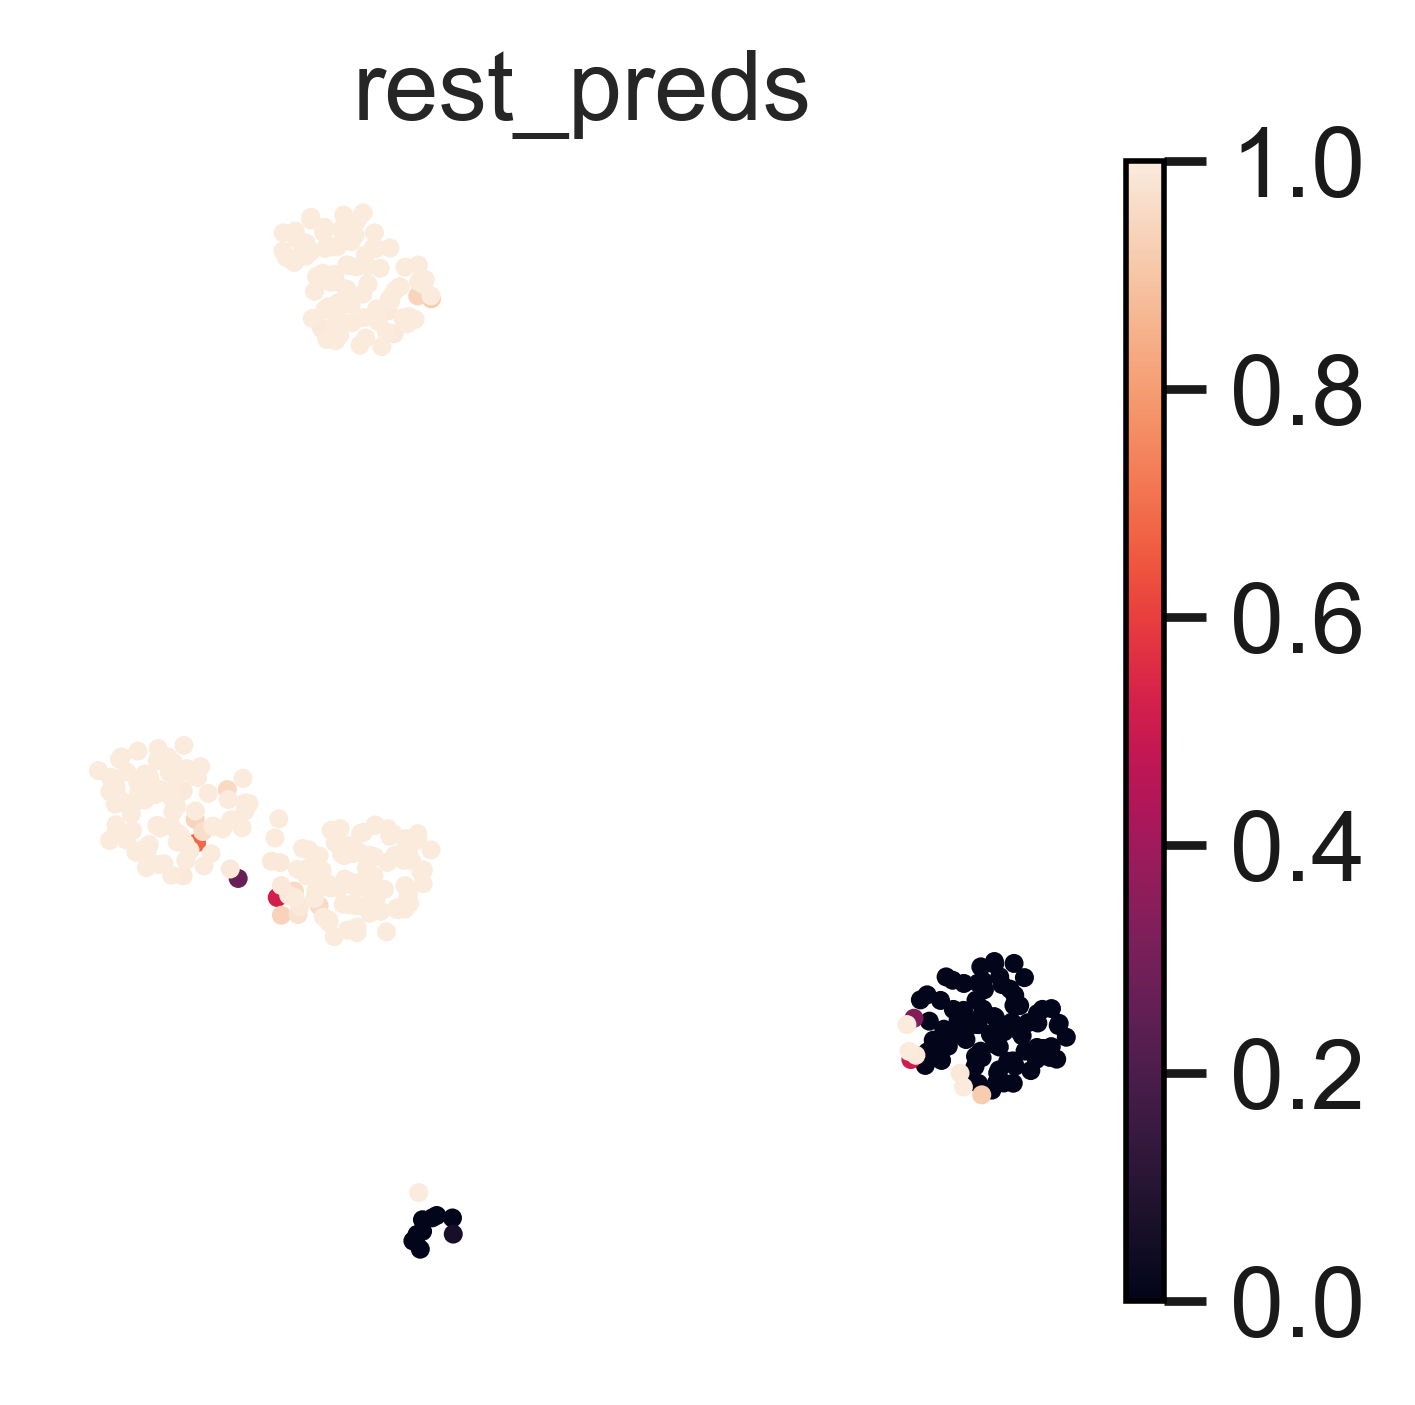

In [191]:
sc.settings.set_figure_params(dpi=250, frameon=False, figsize=(3, 3), facecolor='white')
ax = sc.pl.umap(adata,color=["rest_preds"],size=30,palette="Paired",show=False)
plt.savefig("save/figures/figure2A_2"+name + ".tiff")

In [192]:
adata.obs["Sample name"]

RHH2177      HN120P
RHH2178      HN120P
RHH2179      HN120P
RHH2180      HN120P
RHH2181      HN120P
             ...   
RHH3106    HN120MCR
RHH3107    HN120MCR
RHH3108    HN120MCR
RHH3109    HN120MCR
RHH3110    HN120MCR
Name: Sample name, Length: 368, dtype: category
Categories (4, object): ['HN120M', 'HN120MCR', 'HN120P', 'HN120PCR']

# Show the cell type of the selected dataset

In [183]:
# ax = sc.pl.umap(adata,color=["Sample name"],size=40,palette="Paired",show=False)
# # ax.legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
# plt.savefig("saved/figures/figure2A_3"+name + ".tiff")

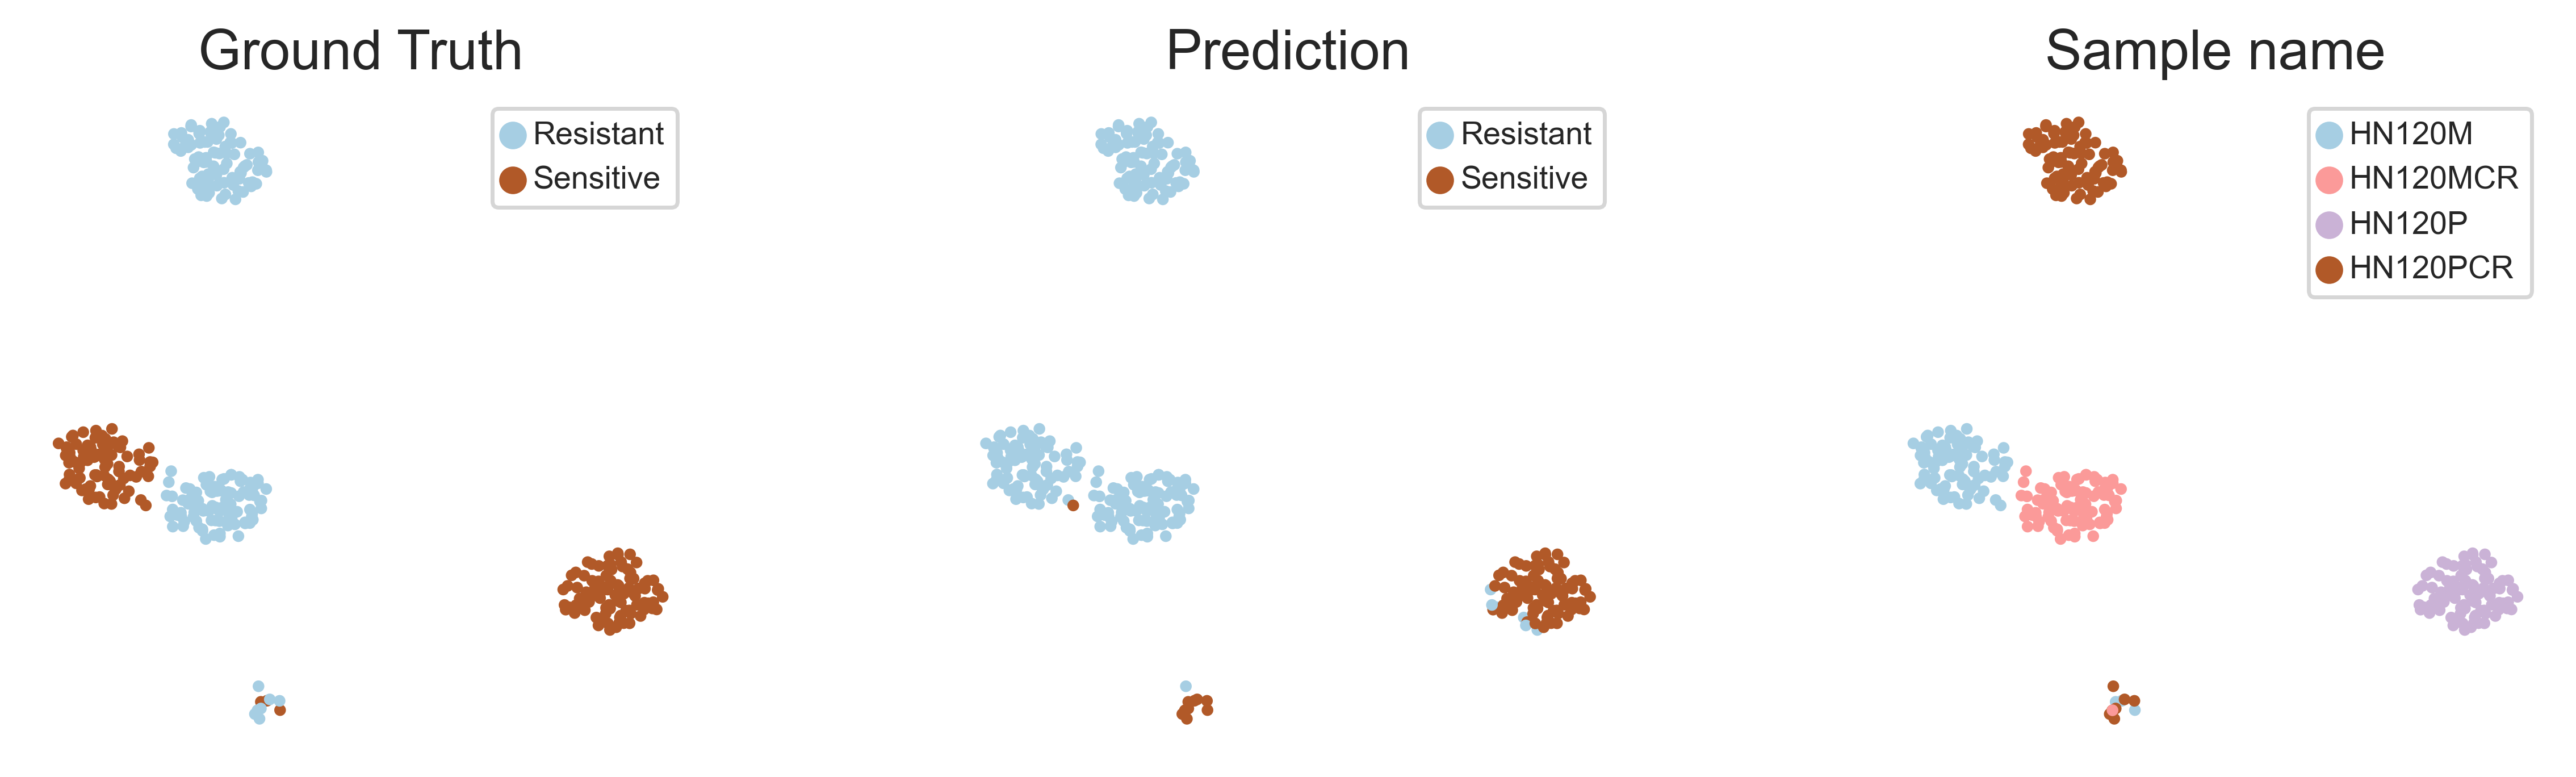

In [193]:
ax = sc.pl.umap(adata,color=['Ground Truth',"Prediction","Sample name"],size=35,palette="Paired",show=False)

ax[0].legend(loc ='upper right', fontsize=8) 
ax[1].legend(loc ='upper right', fontsize=8) 
ax[2].legend(loc ='upper right', fontsize=8) 
#plt.savefig("figure2A_compare"+name + ".tiff")
plt.show()
plt.close()

# Show the gene module score of the sensitive and resistant cell clusters

The sensitive/resistant gene module score is the averaged expression score of the differently express genes within the sensitive/resistant cell cluster

In [194]:
adata = ut.de_score(adata,clustername='pred_binary')

In [195]:
sens_score,s_pval = pearsonr(adata.obs["1_score"],adata.obs["Sensitive_score"])
resistant_score,r_pval = pearsonr(adata.obs["0_score"],adata.obs["Resistant_score"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


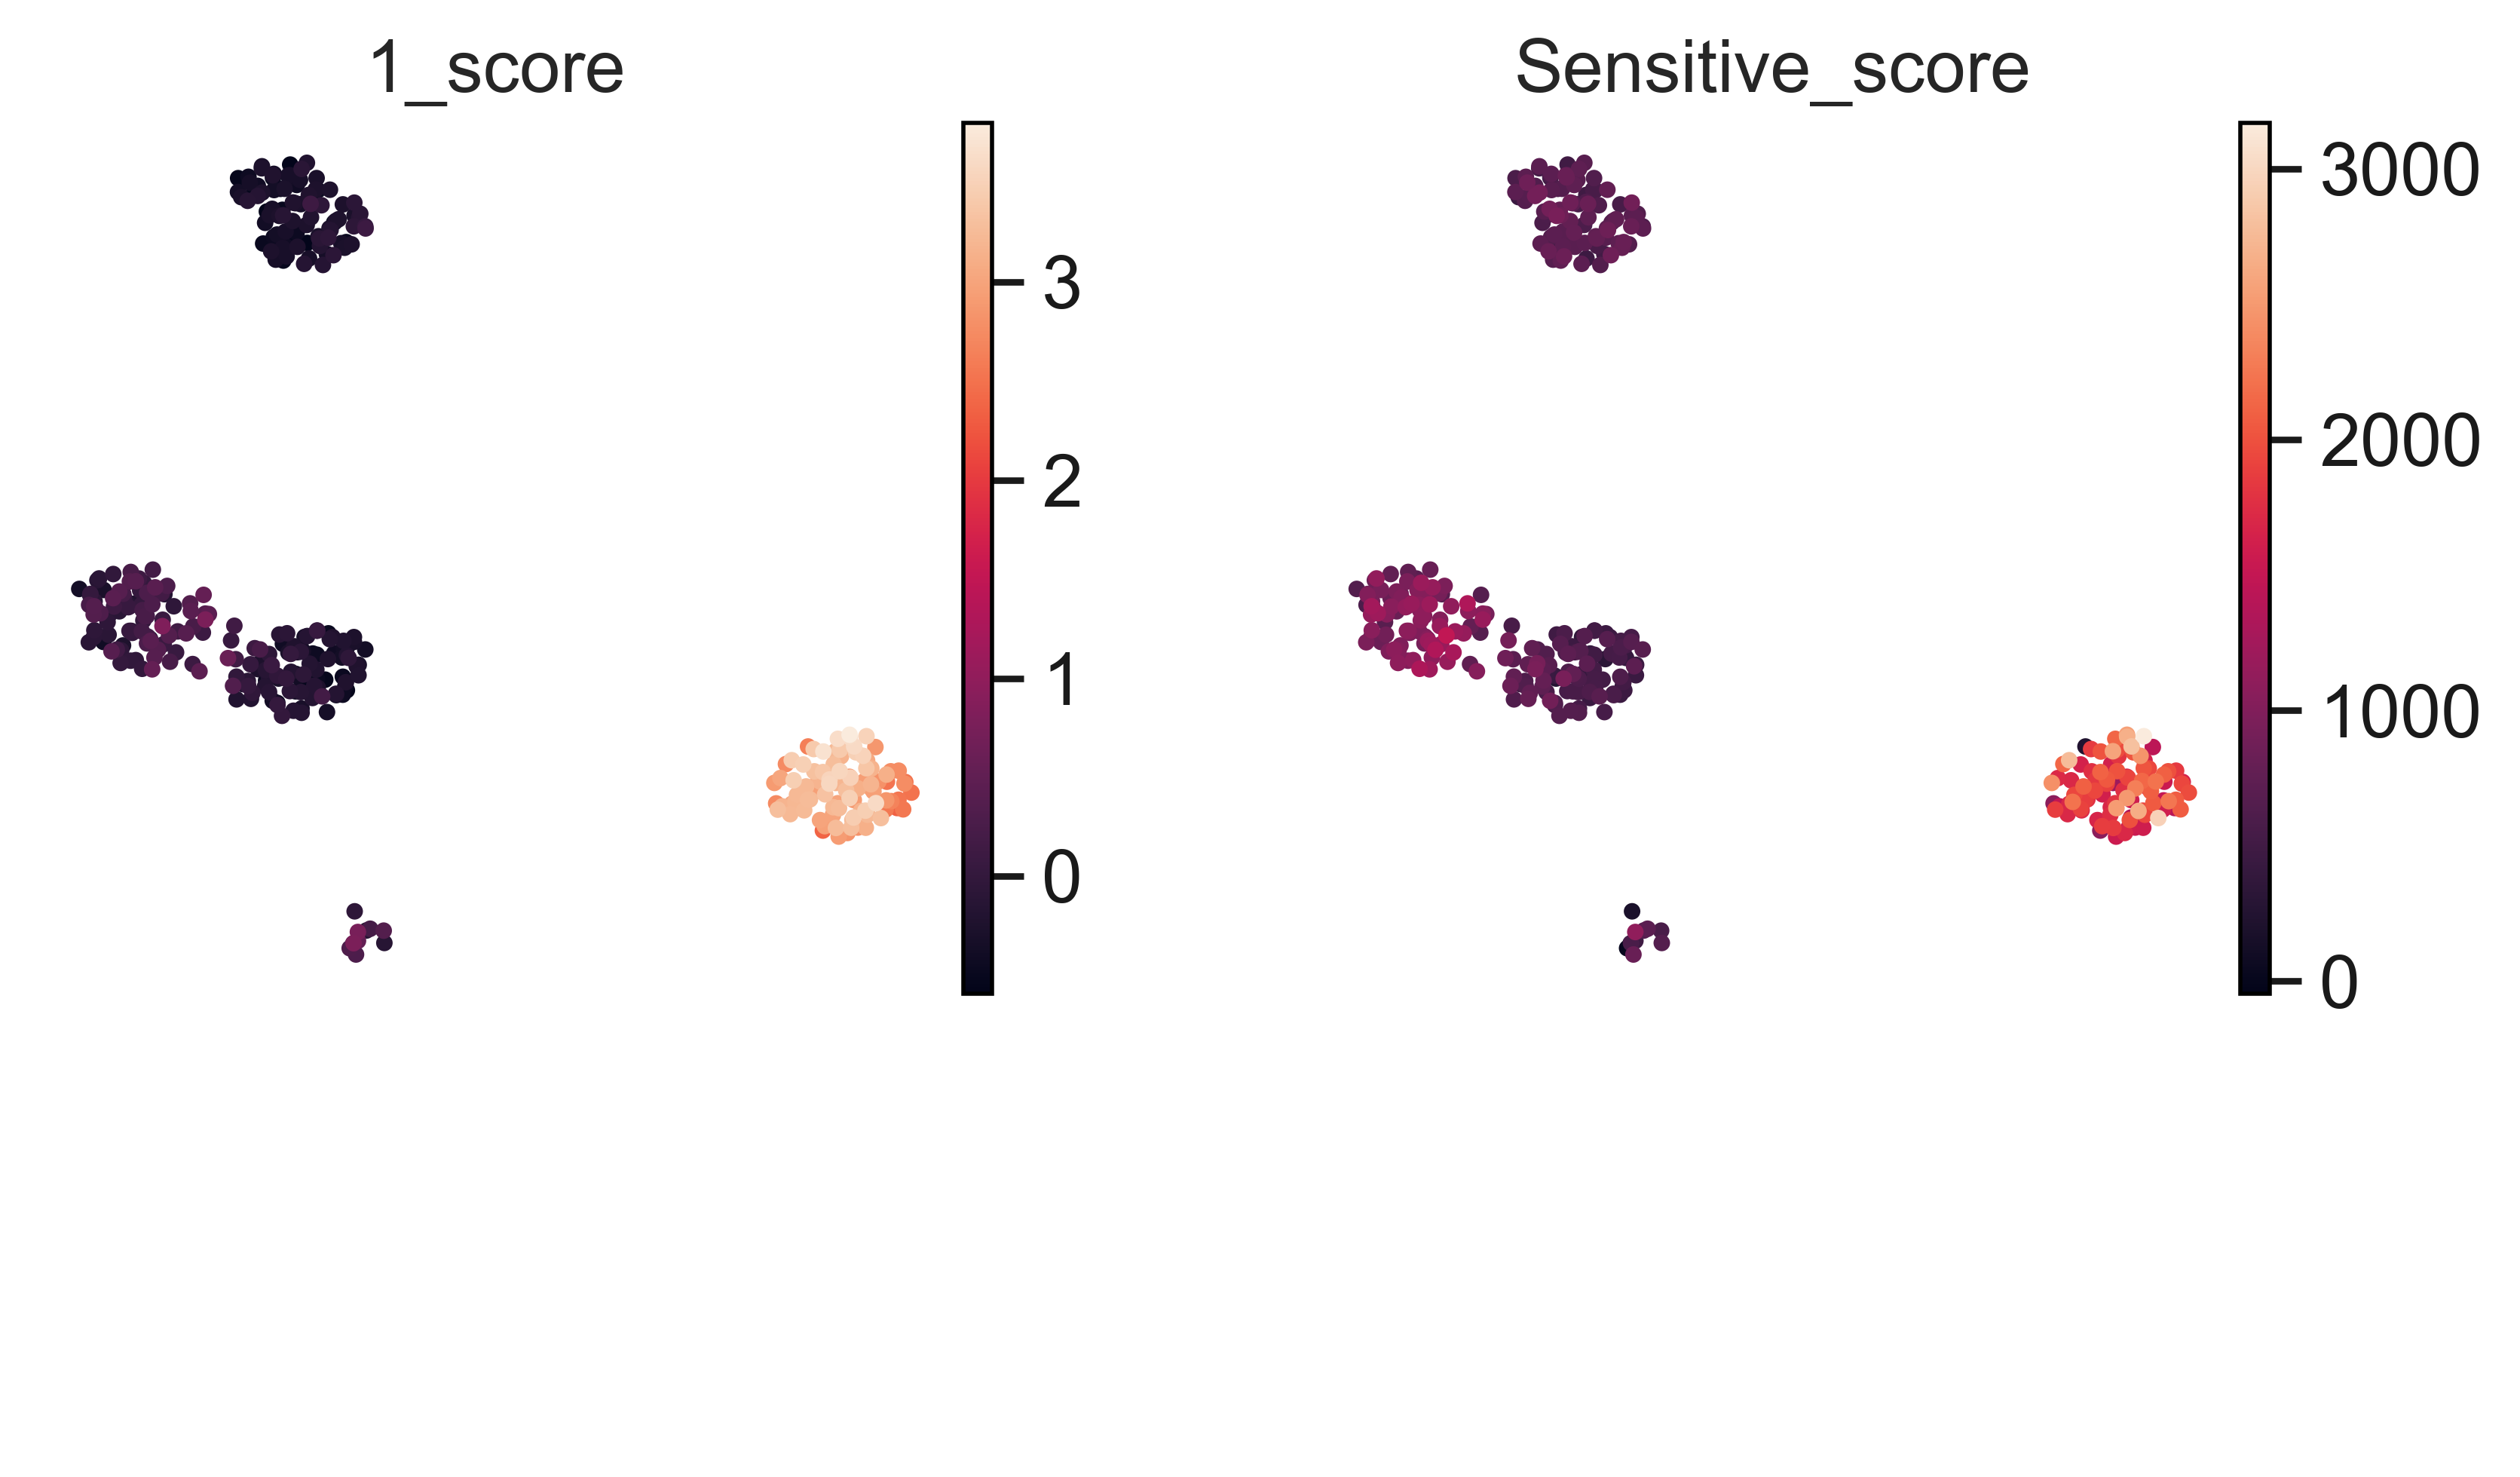

<Figure size 750x750 with 0 Axes>

In [196]:
sc.settings.set_figure_params(dpi=250, frameon=False, figsize=(3, 3), facecolor='white')
ax = sc.pl.umap(adata,color=["1_score","Sensitive_score"],size=40,palette="Set2",show=False)
ax[0].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
ax[1].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
#plt.savefig("save/figures/figure2A_4"+name + ".tiff")
plt.show()
plt.clf()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


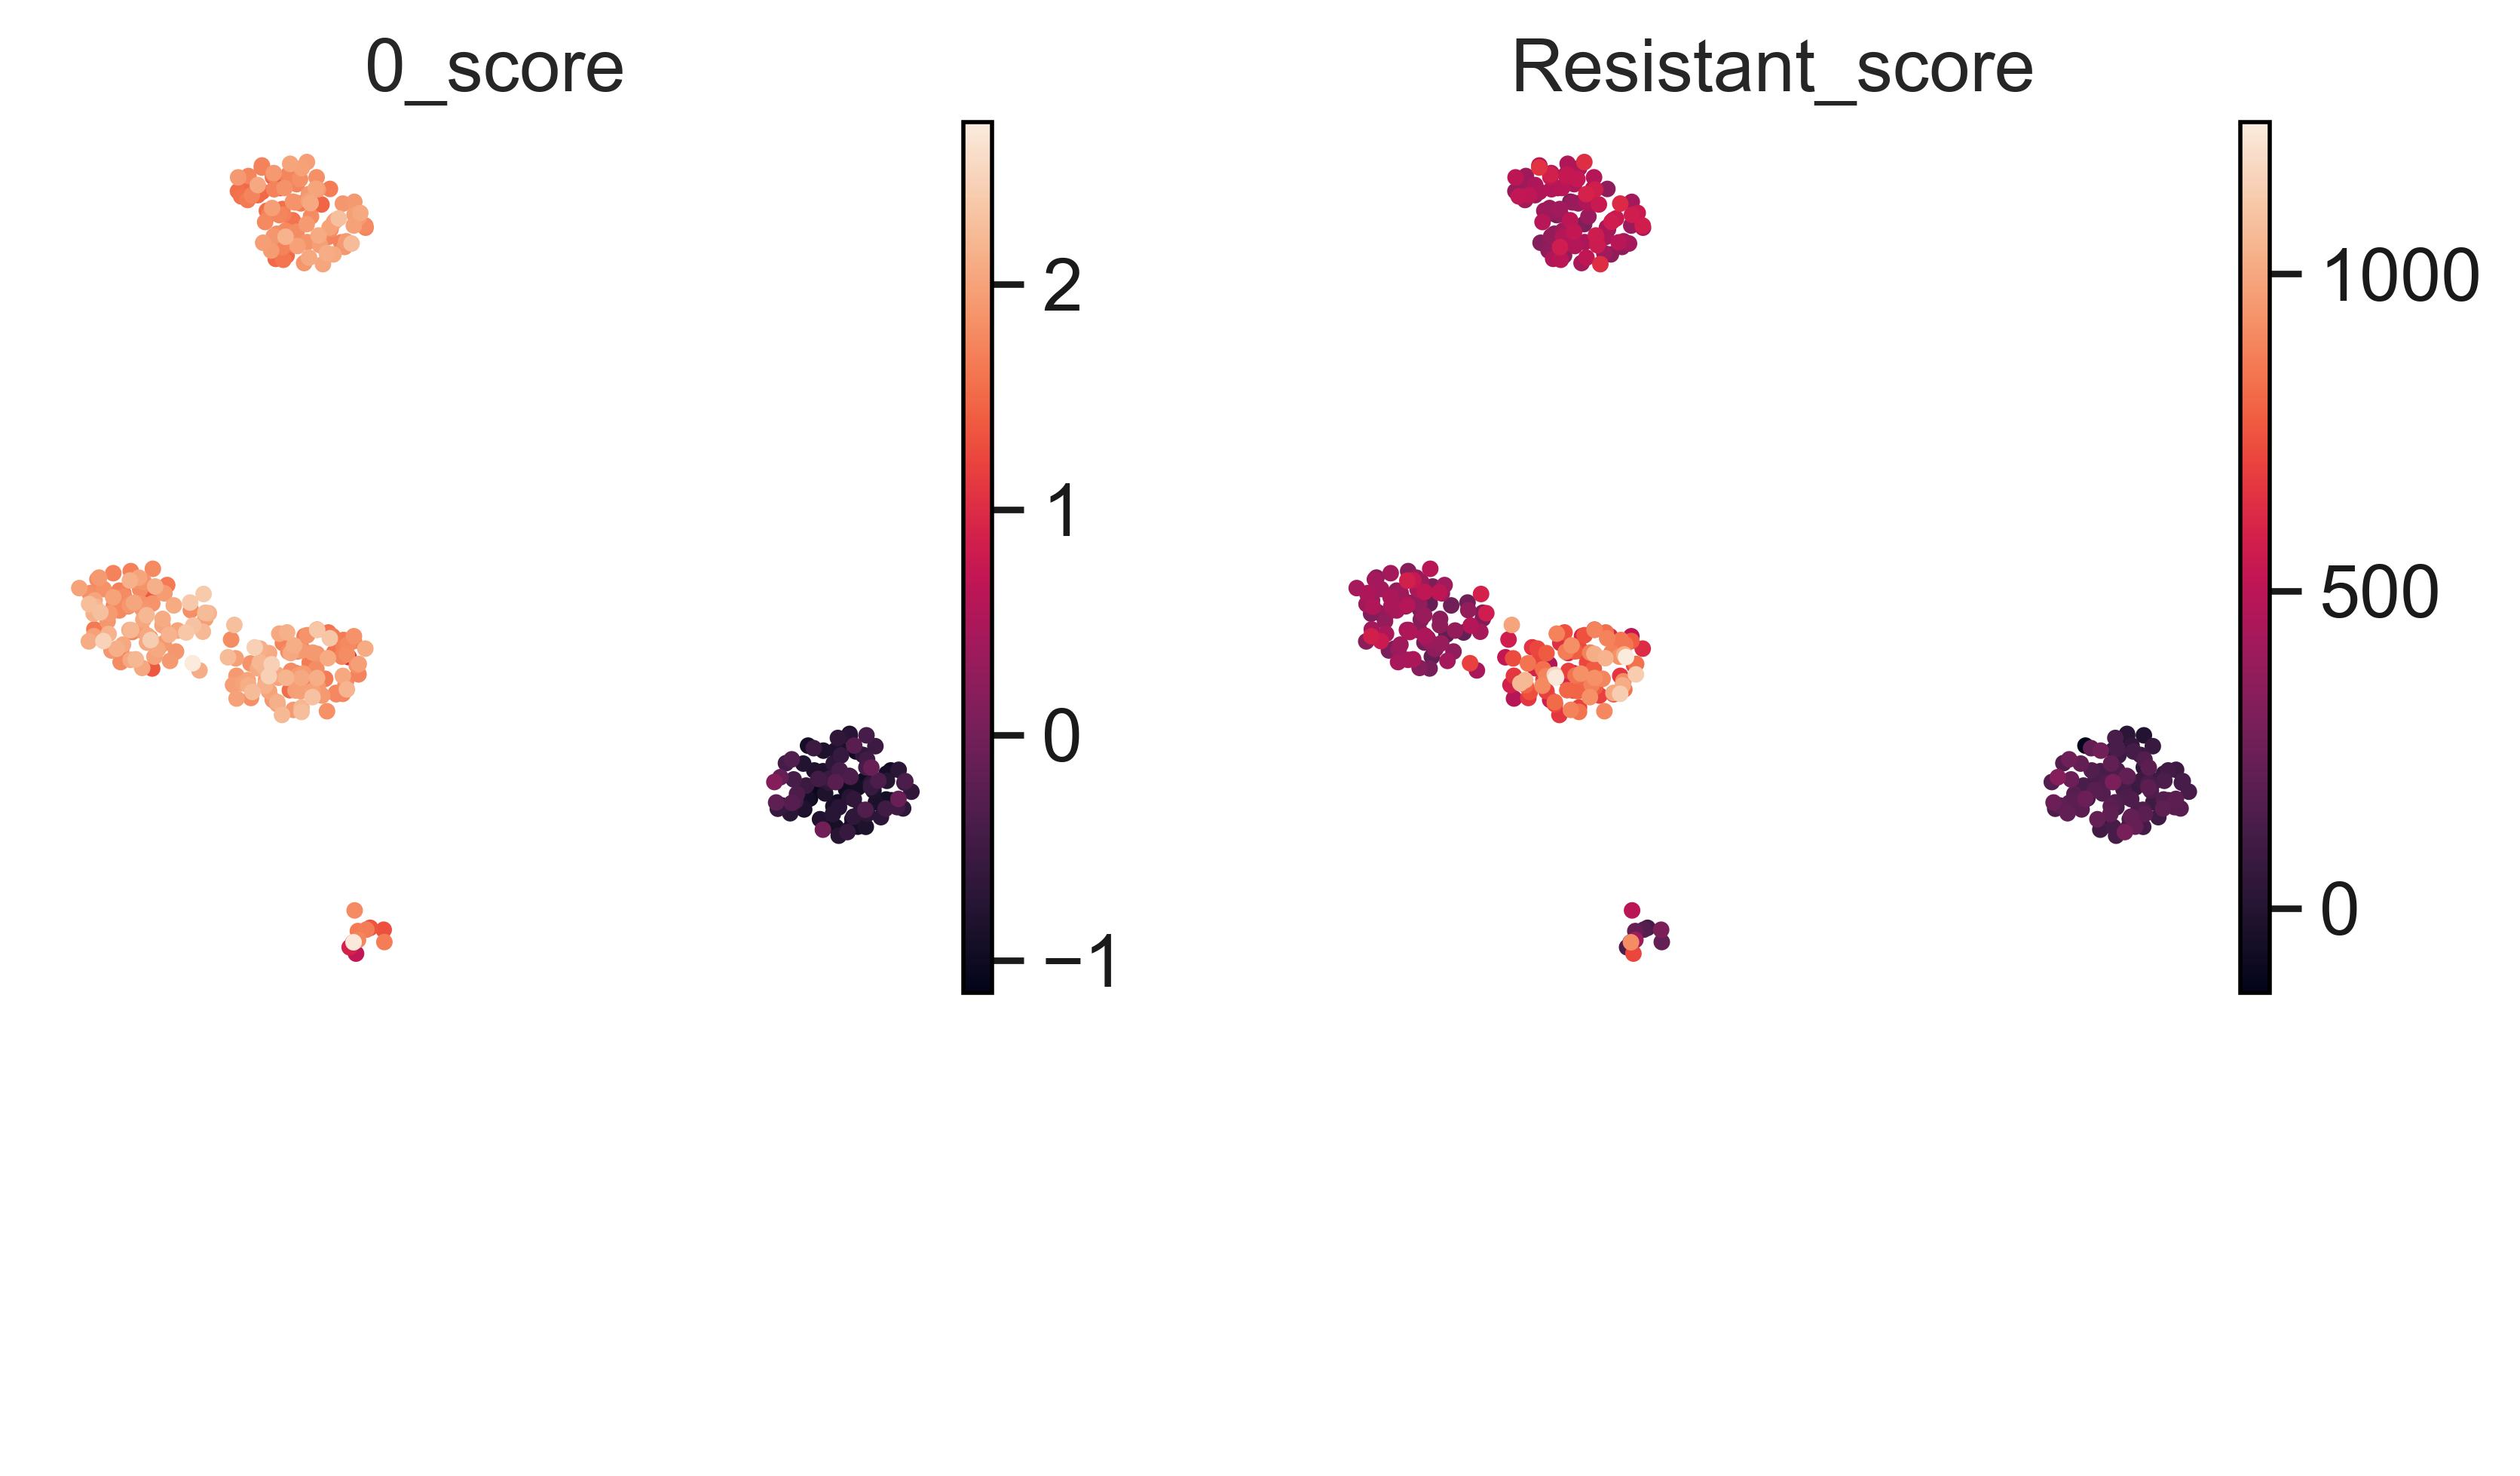

<Figure size 750x750 with 0 Axes>

In [197]:
ax = sc.pl.umap(adata,color=["0_score","Resistant_score"],size=40,palette="flare",show=False)
ax[0].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
ax[1].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
#plt.savefig("save/figures/figure2A_5"+name + ".tiff")
plt.show()
plt.clf()

# pval of the gene module score

In [89]:
def ran_test_score(adata,n_iters=1000):
    ran_results1 = []
    ran_results2 = []

    s_score,s_pval = pearsonr(adata.obs["1_score"],adata.obs["Sensitive_score"])
    r_score,r_pval = pearsonr(adata.obs["0_score"],adata.obs["Resistant_score"])


    for i in range(0,n_iters):

        gl1 = random.sample(list(adata.var.index),50)
        adata=sc.tl.score_genes(adata, gene_list=gl1,score_name="l1_score",copy=True)

        rand_score1,rand_pval1 = pearsonr(adata.obs["l1_score"],adata.obs["Sensitive_score"])
        rand_score2,rand_pval2 = pearsonr(adata.obs["l1_score"],adata.obs["Resistant_score"])

        ran_results1.append(rand_score1)
        ran_results2.append(rand_score2)
        
        
    return adata,ran_results1, s_score,s_pval ,ran_results2,r_score,r_pval

In [198]:
adata,s_ran, s_score,s_pval ,r_ran,r_score,r_pval = ran_test_score(adata,100)

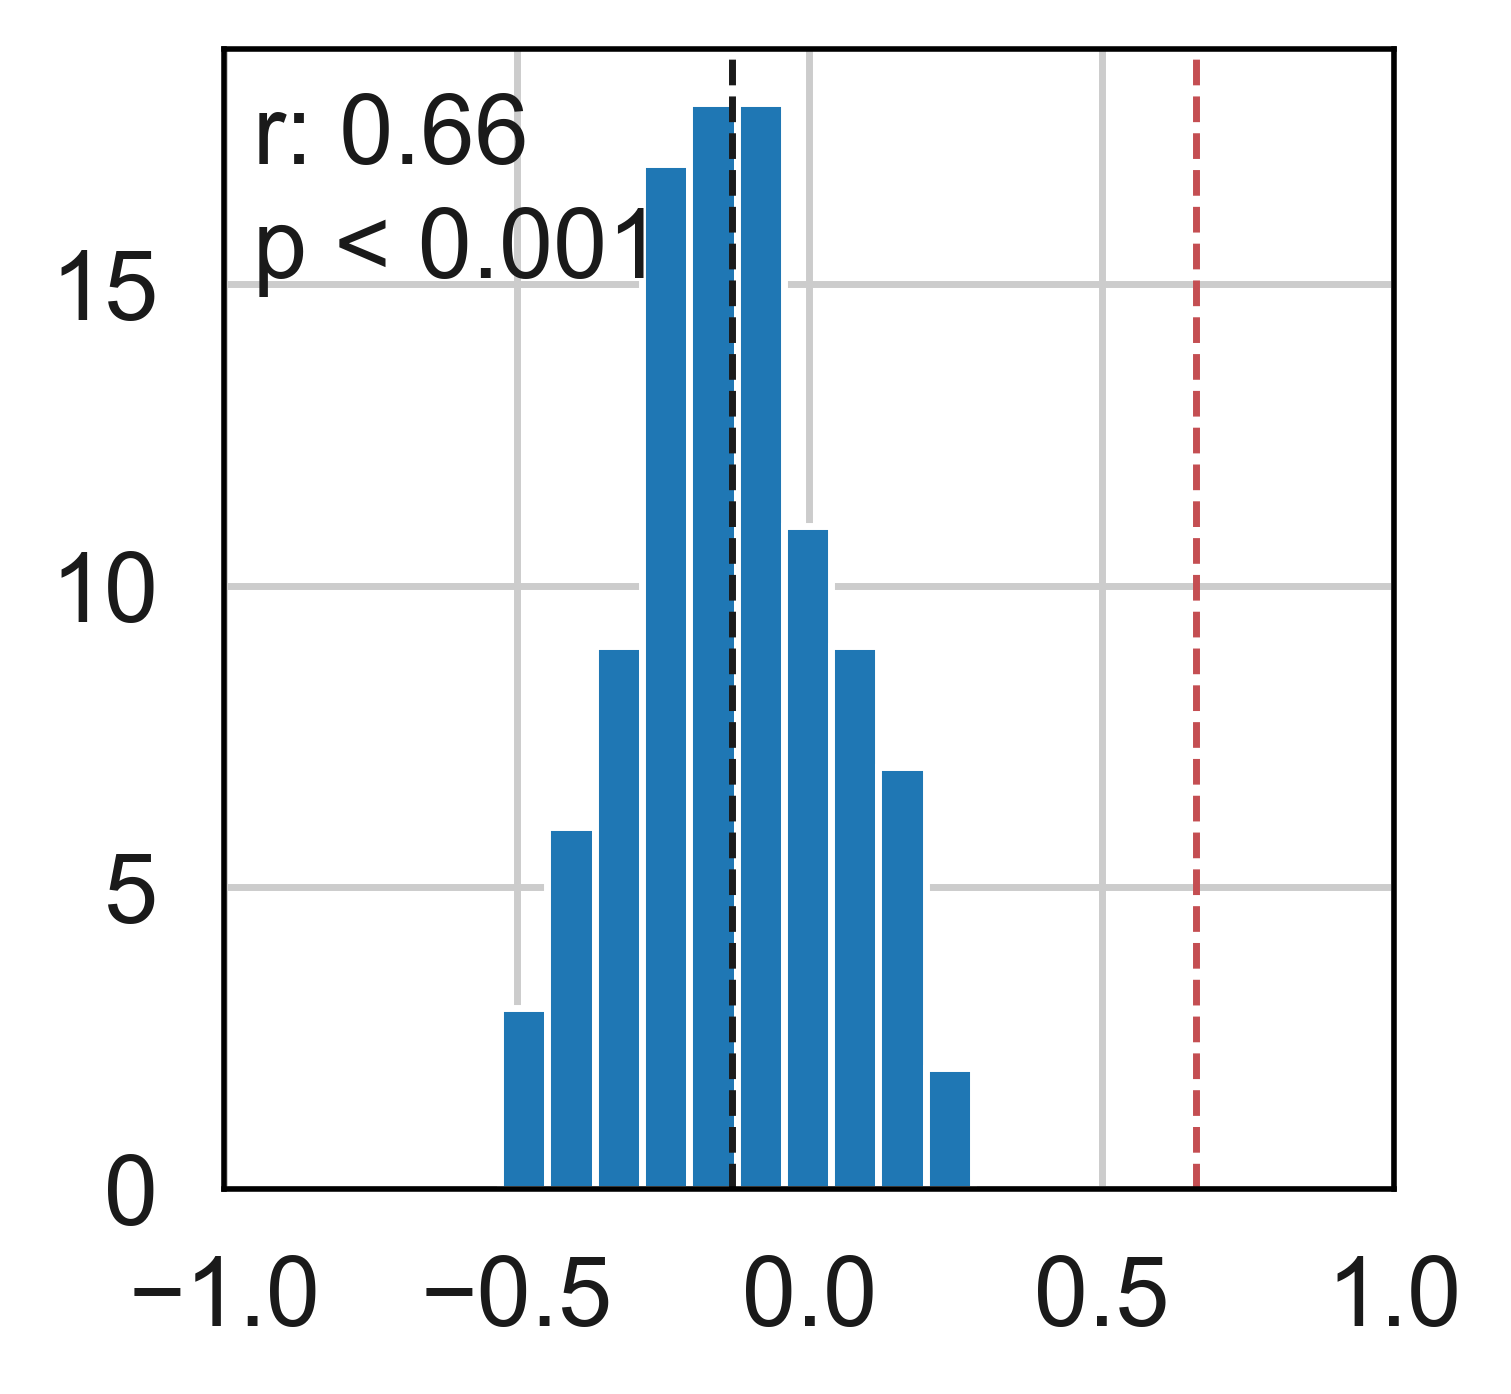

In [199]:
plt.hist(r_ran)
plt.xlim(xmin=-1, xmax = 1)
plt.axvline(r_score, color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(r_ran), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
#plt.text(-1, max_ylim*0.7, 'Mean: {:.2f}'.format(np.mean(r_ran)))
plt.text(-0.95, max_ylim*0.8, 'p < 0.001', color='k')
plt.text(-0.95, max_ylim*0.9, 'r: {:.2f}'.format(r_score), color='k')
plt.show()

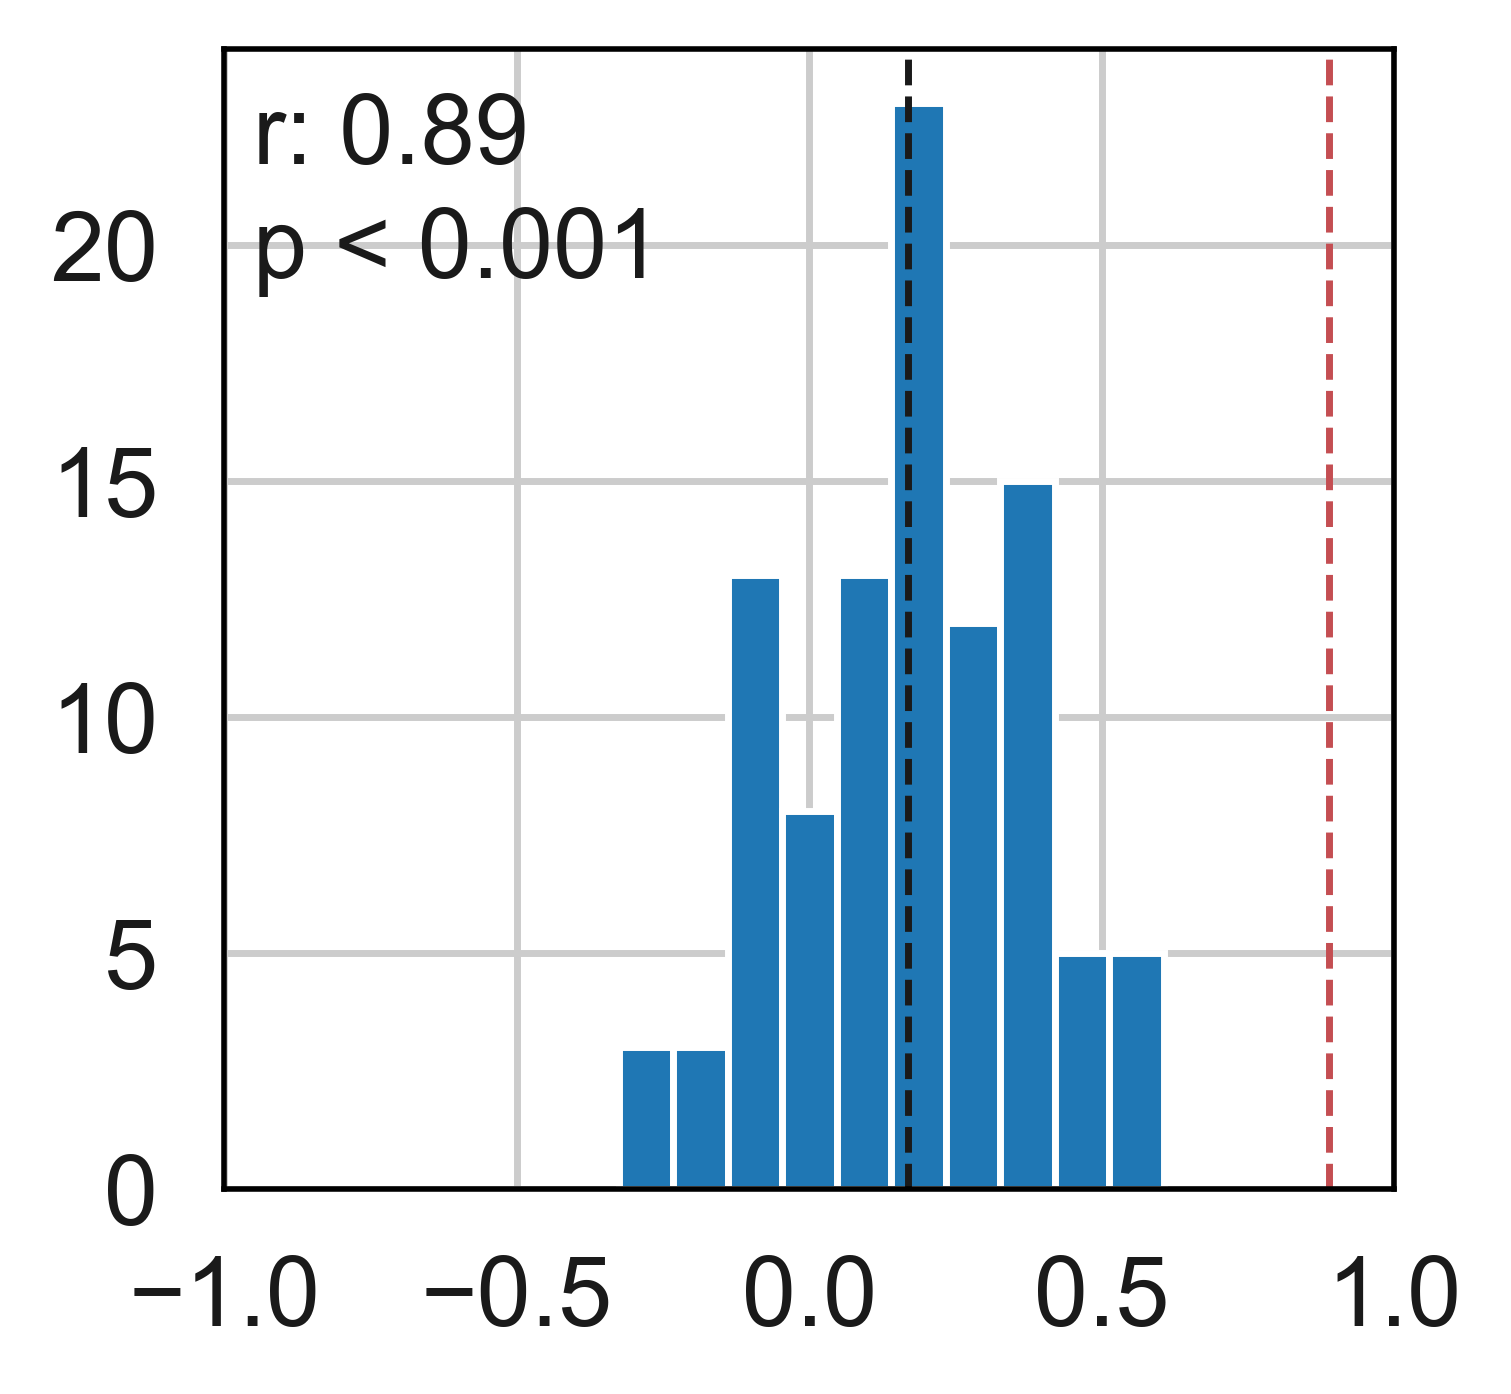

In [200]:
plt.hist(s_ran)
plt.xlim(xmin=-1, xmax = 1)
plt.axvline(s_score, color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(s_ran), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
#plt.text(-1, max_ylim*0.7, 'Mean: {:.2f}'.format(np.mean(r_ran)))
plt.text(-0.95, max_ylim*0.8, 'p < 0.001', color='k')
plt.text(-0.95, max_ylim*0.9, 'r: {:.2f}'.format(s_score), color='k')
plt.savefig("save/figures/random_senstive_gene"+name + '.svg')
plt.show()

# Show the correlation between the gene score and the prediction cell type

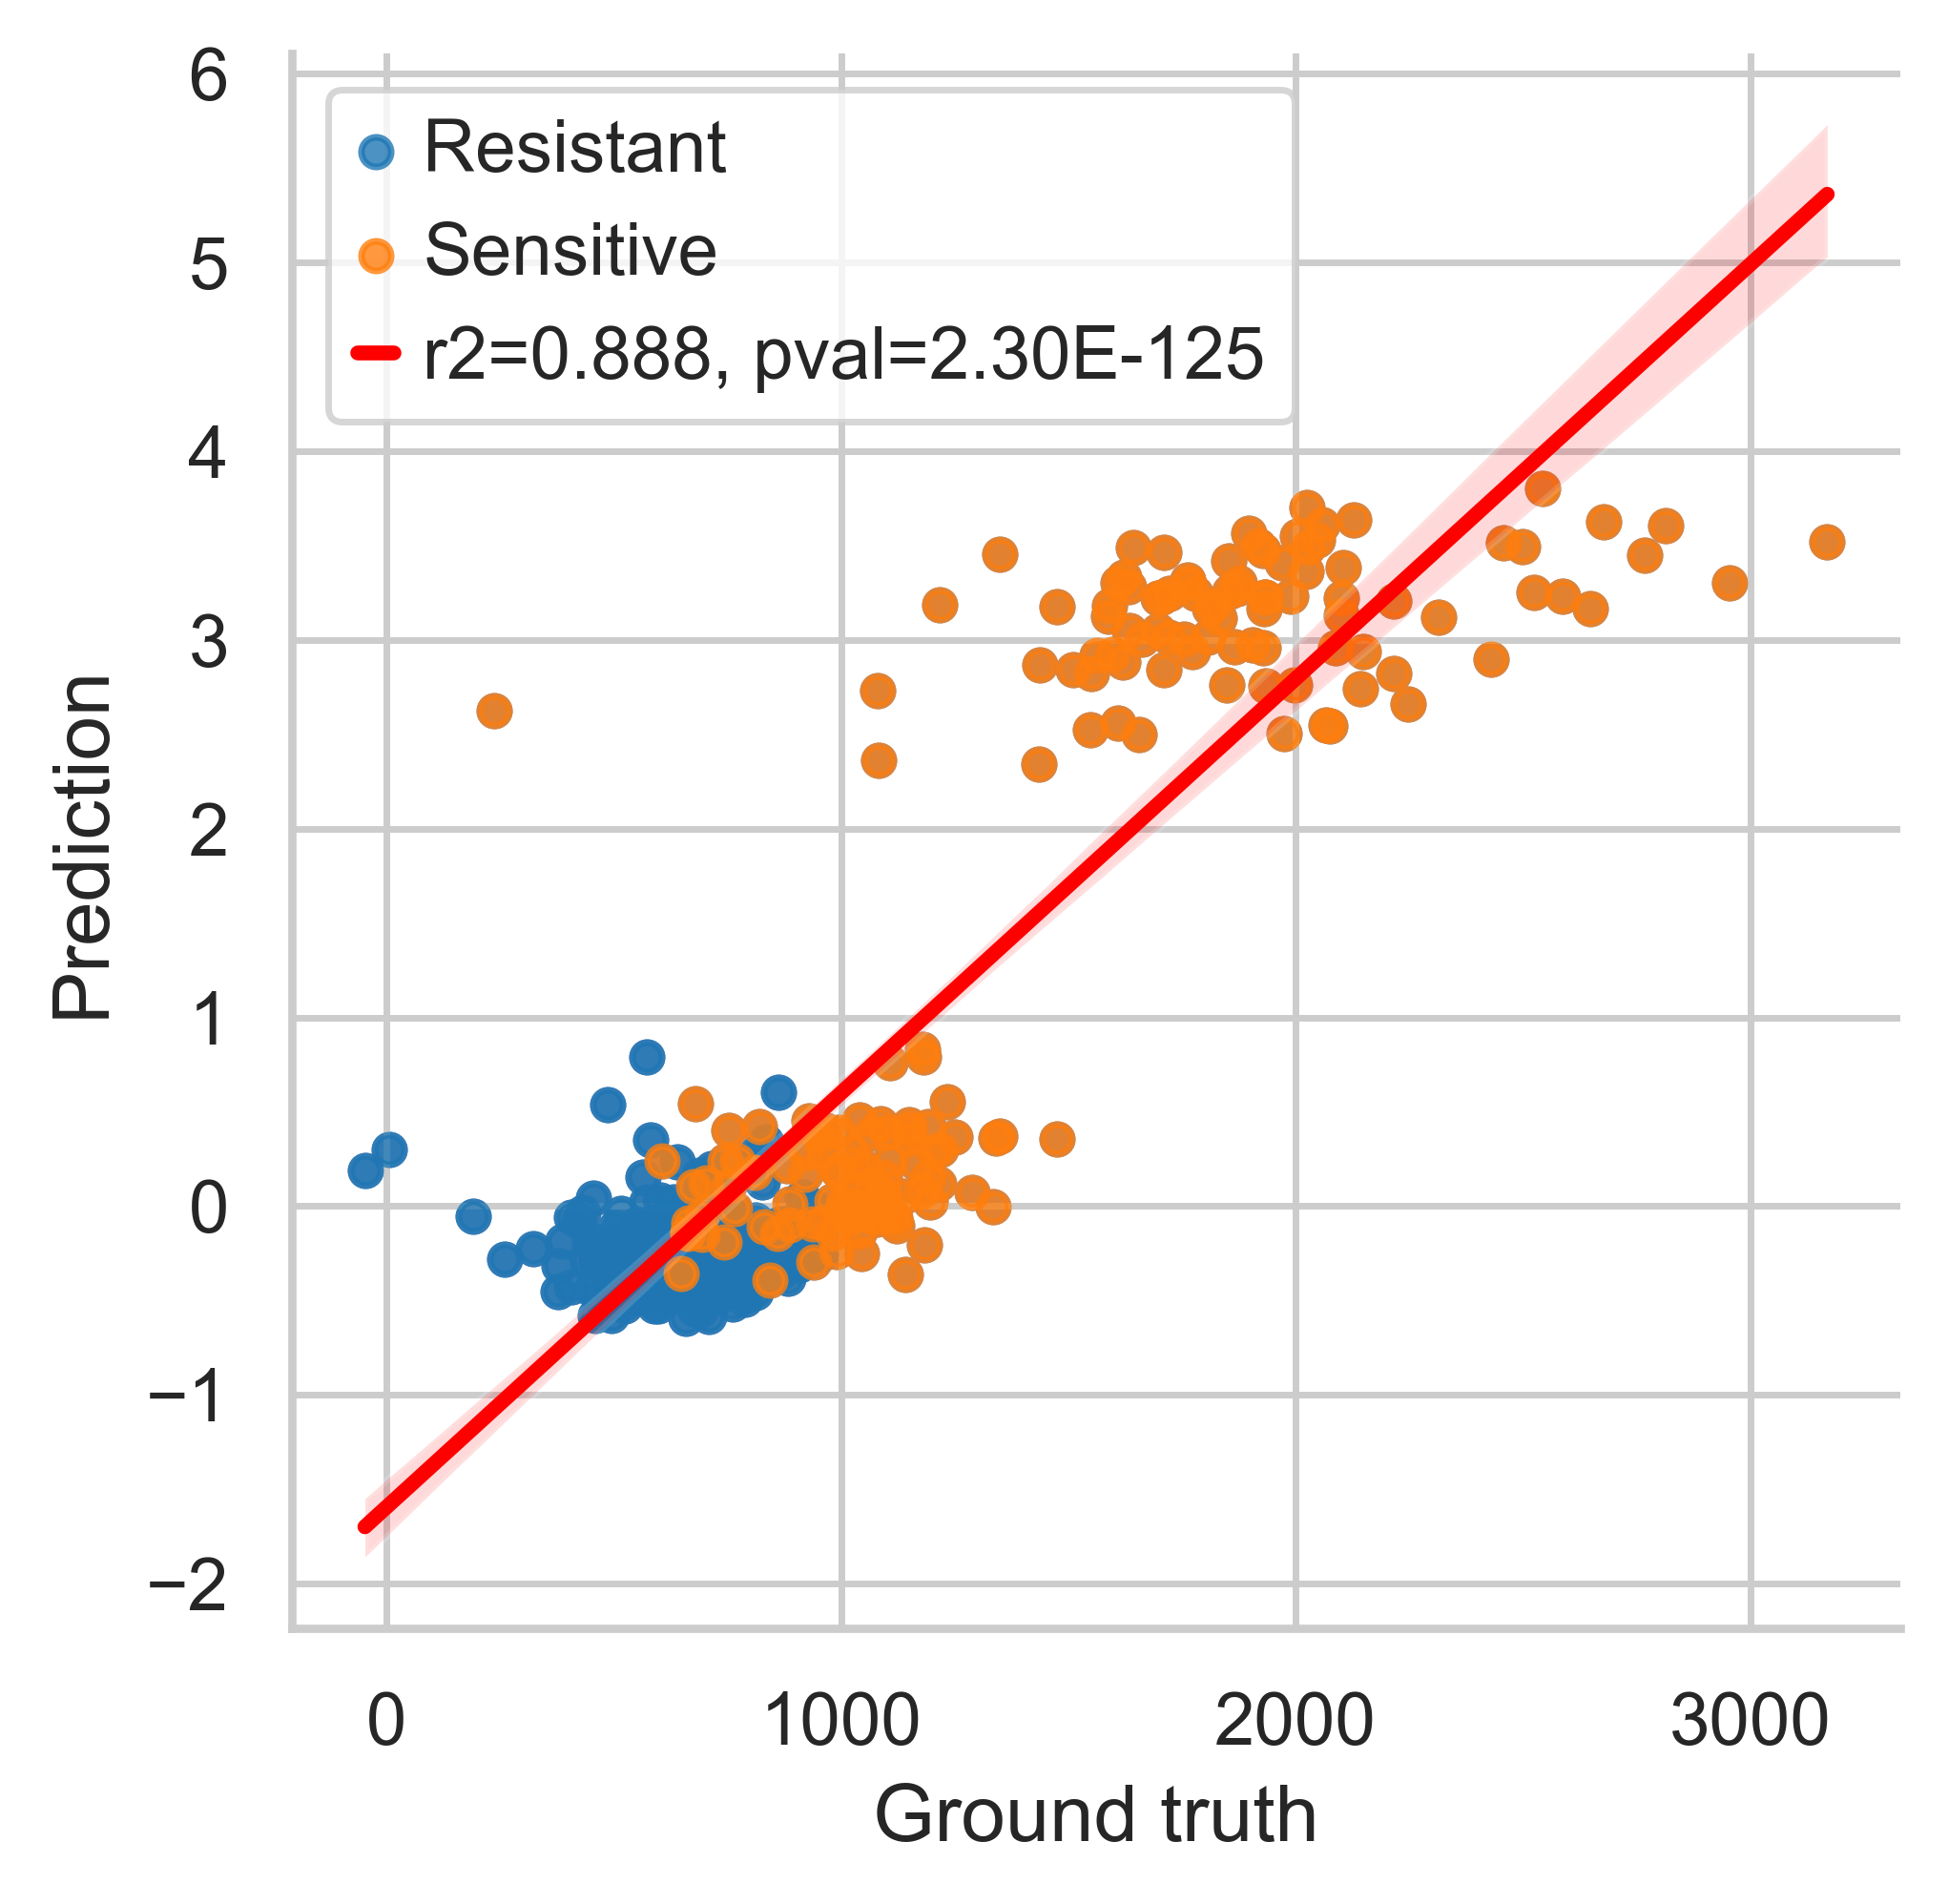

<Figure size 750x750 with 0 Axes>

In [201]:
import scipy as sp
from sklearn.preprocessing import MinMaxScaler

sns.set_theme(style="whitegrid")

score_1 = adata.obs.loc[:,'Sensitive_score'].ravel()
score_2 = adata.obs.loc[:,'1_score'].ravel()
c = adata.obs.loc[:,"Ground Truth"].values


scaler = MinMaxScaler()

DF_0 = pd.DataFrame({"Ground truth":score_1,"Prediction":score_2,"color":c})


r, p = sp.stats.pearsonr(score_1, score_2)

line_kws={'label':"r2={0:.3f}, pval={1:.2E}".format(r,p),"color":"red"}

sns.lmplot(x='Ground truth', y='Prediction', hue='color', data=DF_0, fit_reg=False, legend=False,scatter_kws={"s":20},\
           #palette=sns.color_palette("tab10_r",10)[8:10]
           palette=sns.color_palette("tab10",2)
)

ax = sns.regplot(x=score_1, y=score_2,logx=False, line_kws=line_kws, scatter_kws={"zorder":-1,"s":20})
ax.legend(loc='upper left')
ax.figure.set_size_inches(4, 4)

sns.despine(left=False)
plt.show()
#plt.savefig("save/figures/Regplot_sesistive_"+name+".tiff")
plt.clf()


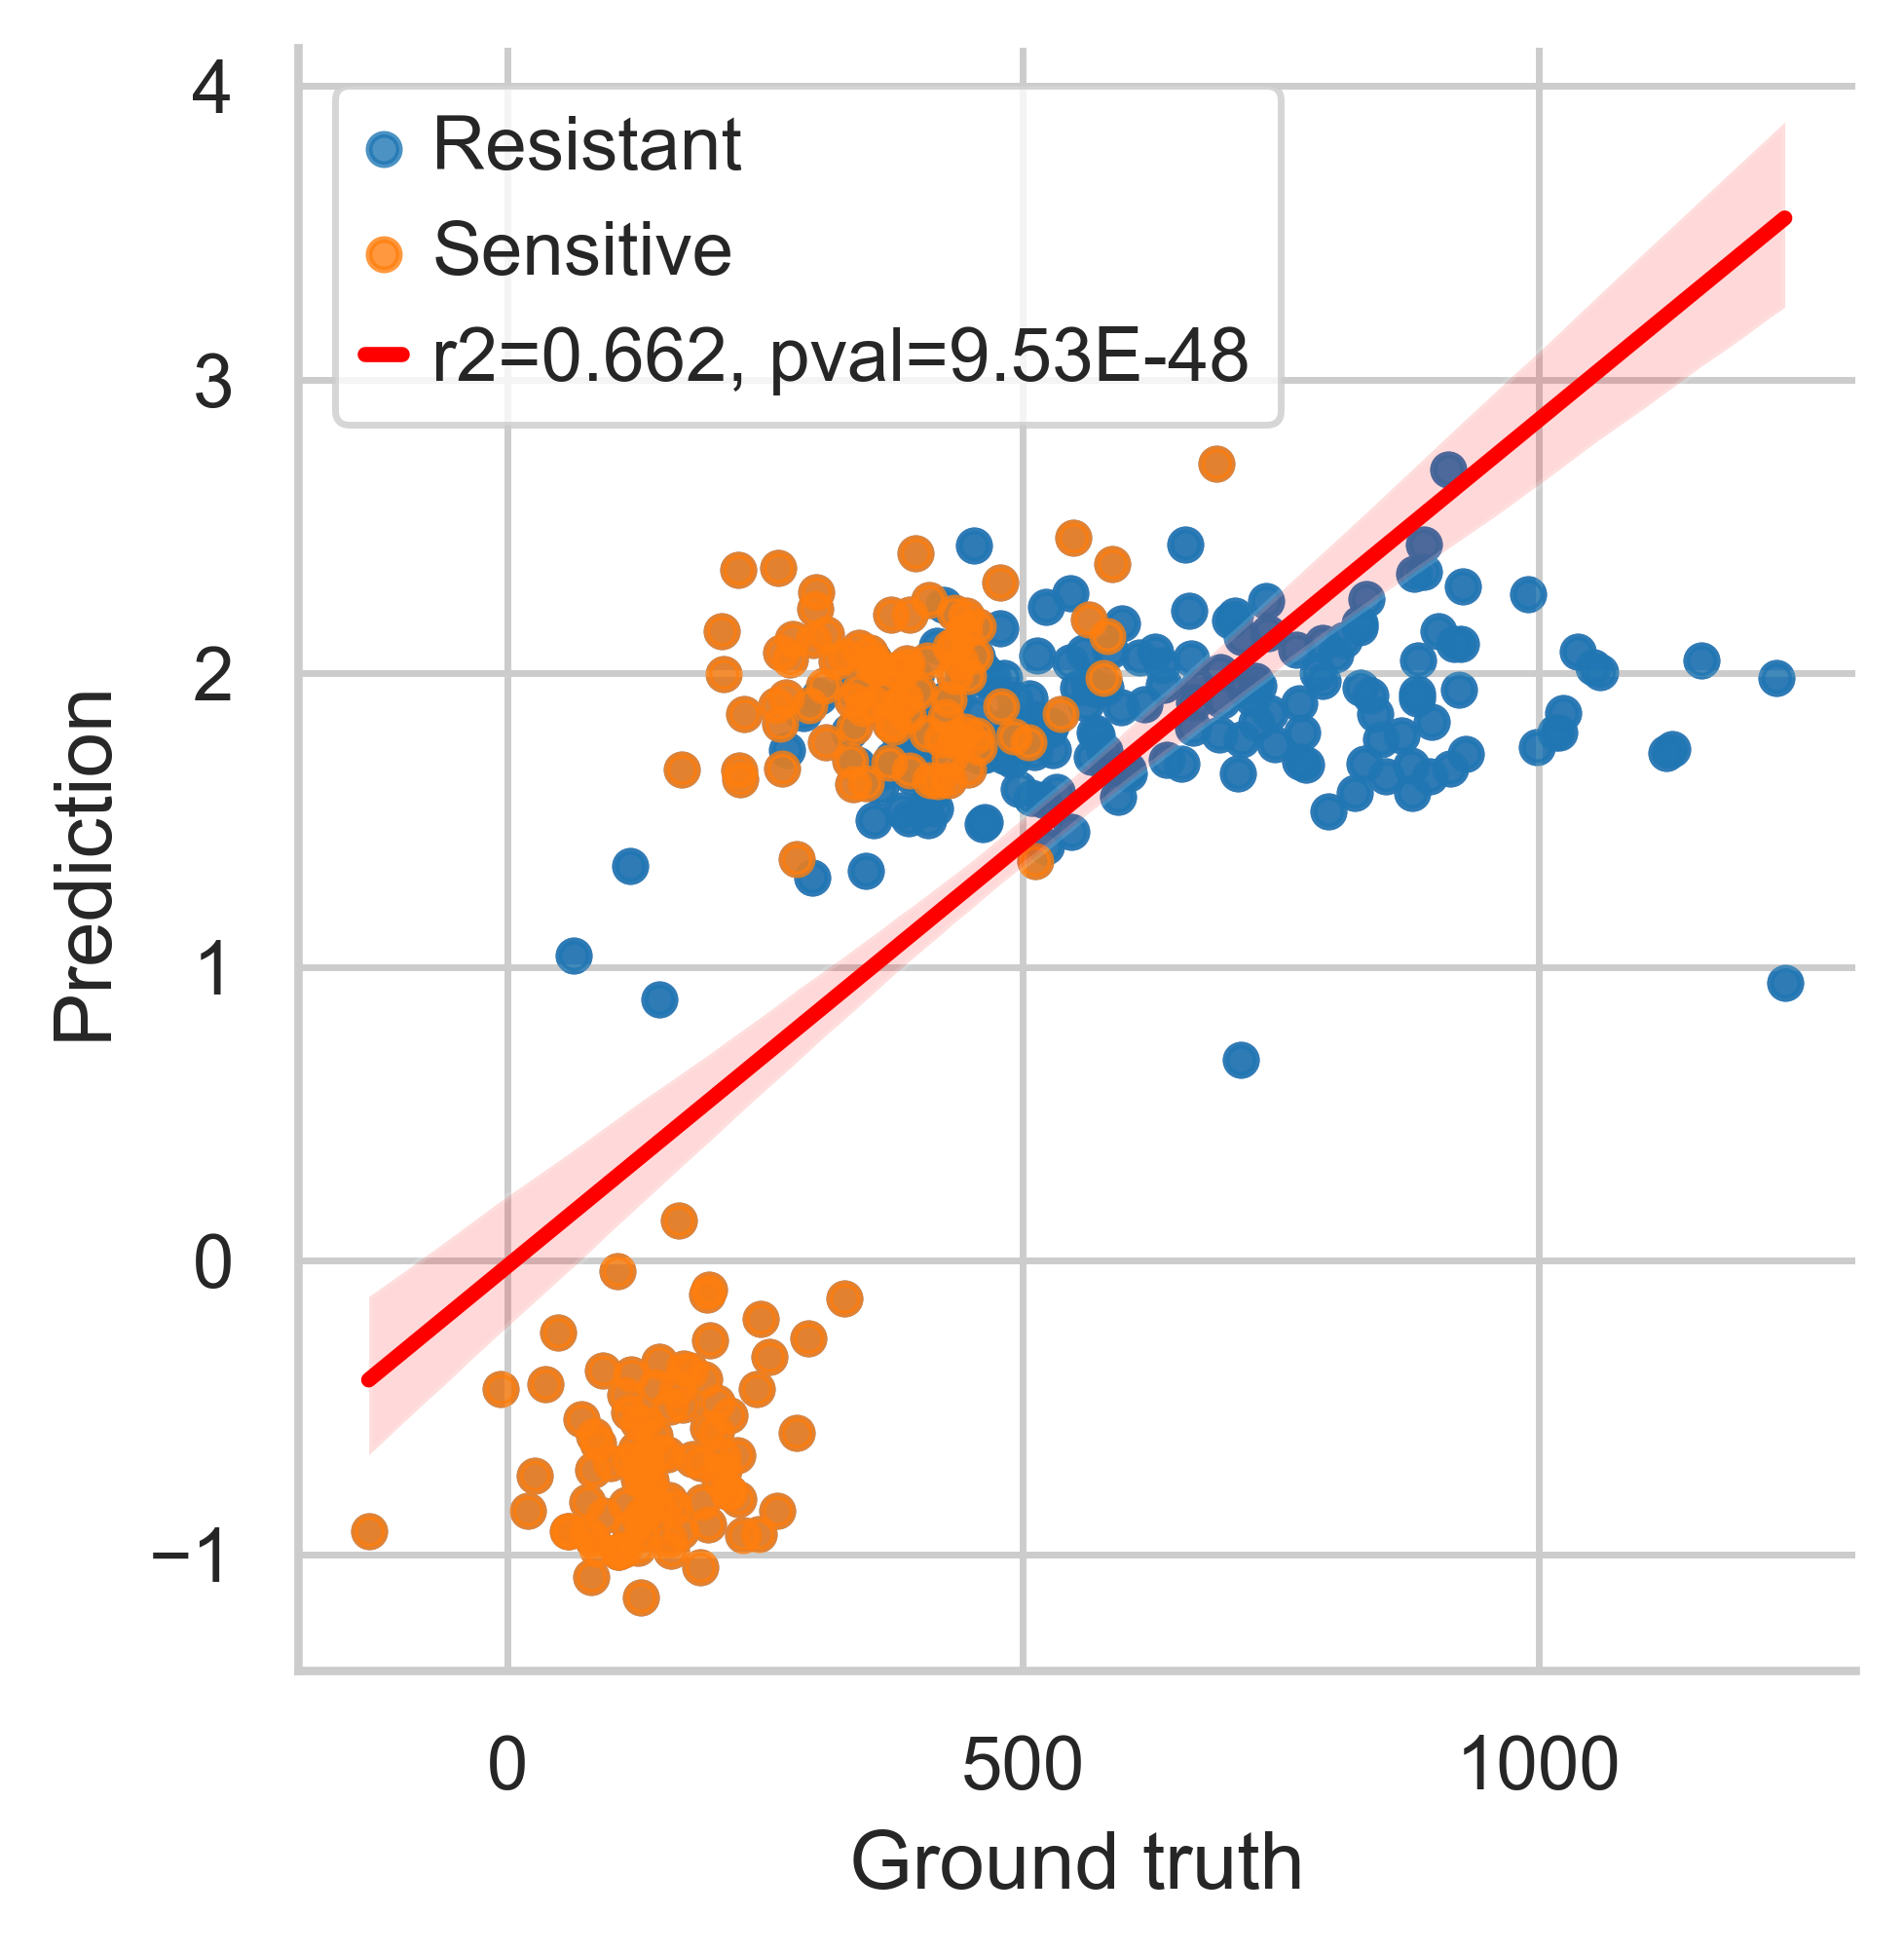

<Figure size 750x750 with 0 Axes>

In [202]:
score_1 = adata.obs.loc[:,'Resistant_score'].ravel()
score_2 = adata.obs.loc[:,'0_score'].ravel()
c = adata.obs.loc[:,"Ground Truth"].values

# score_1 = np.clip(score_1,np.percentile(score_1, 5),np.percentile(score_1, 95))
# score_2 = np.clip(score_2,np.percentile(score_2, 5),np.percentile(score_2, 95))

DF_0 = pd.DataFrame({"Ground truth":score_1,"Prediction":score_2,"color":c})


r, p = sp.stats.pearsonr(score_1, score_2)

line_kws={'label':"r2={0:.3f}, pval={1:.2E}".format(r,p),"color":"red"}

sns.lmplot(x='Ground truth', y='Prediction', hue='color', data=DF_0, fit_reg=False, legend=False,scatter_kws={"s":20},\
           #palette=sns.color_palette("tab10_r",10)[8:10]
           palette=sns.color_palette("tab10",2)

)

# Use regplot to plot the regression line and use line_kws to set line label for legend
#ax = sns.regplot(x="x", y="y", data=DF_0, scatter_kws={"zorder":-1},

ax = sns.regplot(x=score_1, y=score_2,logx=False, line_kws=line_kws, scatter_kws={"zorder":-1,"s":20})
ax.legend(loc='upper left')
ax.figure.set_size_inches(4, 4)

sns.despine(left=False)
#plt.savefig("save/figures/Regplot_resistant_"+name+".tiff")
plt.show()
plt.clf()

In [169]:
r_pval

5.138285256049582e-69